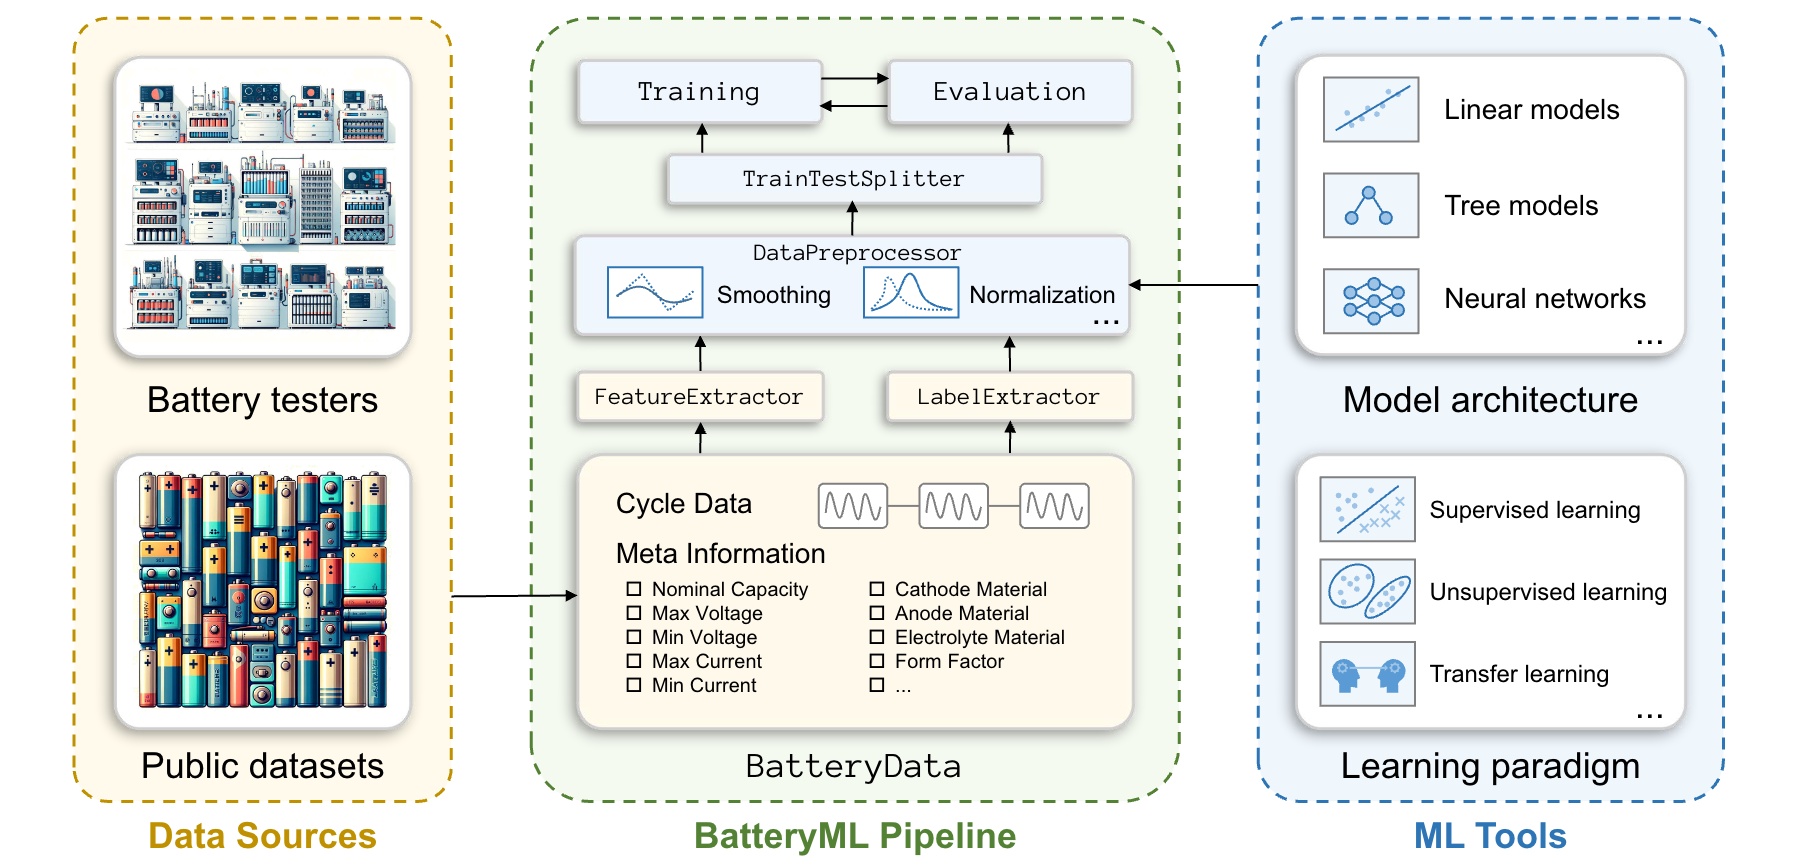

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/battery-and-heating-data-in-real-driving-cycles/TripB31.csv
/kaggle/input/battery-and-heating-data-in-real-driving-cycles/TripB22.csv
/kaggle/input/battery-and-heating-data-in-real-driving-cycles/TripA07.csv
/kaggle/input/battery-and-heating-data-in-real-driving-cycles/TripB18.csv
/kaggle/input/battery-and-heating-data-in-real-driving-cycles/TripB35.csv
/kaggle/input/battery-and-heating-data-in-real-driving-cycles/TripA30.csv
/kaggle/input/battery-and-heating-data-in-real-driving-cycles/TripB34.csv
/kaggle/input/battery-and-heating-data-in-real-driving-cycles/TripB24.csv
/kaggle/input/battery-and-heating-data-in-real-driving-cycles/TripA15.csv
/kaggle/input/battery-and-heating-data-in-real-driving-cycles/TripA18.csv
/kaggle/input/battery-and-heating-data-in-real-driving-cycles/TripB12.csv
/kaggle/input/battery-and-heating-data-in-real-driving-cycles/TripA27.csv
/kaggle/input/battery-and-heating-data-in-real-driving-cycles/TripB36.csv
/kaggle/input/battery-and-heating-data

In [2]:
import pandas as pd
import numpy as np
import os, chardet, glob
import matplotlib.pyplot as plt
import seaborn

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras import Sequential, optimizers, losses, layers

%matplotlib inline

In [3]:
df_overview = pd.read_excel('../input/battery-and-heating-data-in-real-driving-cycles/Overview.xlsx')
df_overview = df_overview.drop(['Unnamed: 13','Note'], axis=1)
df_overview = df_overview.dropna()
df_overview.rename(columns = {'Unnamed: 8':'SoC difference'}, inplace = True)
df_overview.head()

Trip                 Date   Route/Area Weather  \
0  TripA01  2019-06-25_13-21-14  Munich East   sunny   
1  TripA02  2019-06-25_14-05-31  Munich East   sunny   
2  TripA03  2019-06-28_10-02-15  Munich East   sunny   
3  TripA04  2019-06-28_10-13-30  Munich East   sunny   
4  TripA05  2019-06-28_10-20-26  Munich East   sunny   

   Battery Temperature (Start) [°C]  Battery Temperature (End)  \
0                              21.0                       22.0   
1                              23.0                       26.0   
2                              24.0                       25.0   
3                              25.0                       27.0   
4                              27.0                       27.0   

   Battery State of Charge (Start)  Battery State of Charge (End)  \
0                            0.863                          0.803   
1                            0.803                          0.673   
2                            0.835                          0.751   
3                            0.751                          0.667   
4                            0.667                          0.602   

   SoC difference  Ambient Temperature (Start) [°C]  Target Cabin Temperature  \
0           0.060                              25.5                      23.0   
1           0.130                              32.0                      23.0   
2           0.084                              21.5                      27.0   
3           0.084                              24.0                      22.0   
4           0.065                              24.5                      24.0   

   Distance [km]  Duration [min]                 Fan  
0       7.427690       16.820000  Automatic, Level 1  
1      23.509709       23.550000  Automatic, Level 1  
2      12.820846       11.180000  Automatic, Level 1  
3      10.727491        6.870000  Automatic, Level 1  
4      12.393223       22.776667  Automatic, Level 1

In [4]:

def combine_csvs():
    '''Combine all csv datasets into a single file with downsampling'''
    df_master = pd.DataFrame()
    for filename in glob.glob('../input/battery-and-heating-data-in-real-driving-cycles/'+'*.csv'):
        df_trip = pd.read_csv(
            filename,
            sep=';',
            encoding=chardet.detect(open(filename, 'rb').read())['encoding']
        )
        # Downsample here (keep every 10th row)
        df_trip = df_trip.iloc[::10, :]

        df_master = pd.concat([df_master, df_trip])

    df_master.to_csv('../input/battery-and-heating-data-in-real-driving-cycles/AllTrips.csv', index=False)
    return df_master


def plot_dataframe_subplots(df, nrows, ncols, figsize=(30, 24)):
    """Plot a nrows x ncols grid of the df variables"""
    measurements = list(df.columns)
    plt.figure(figsize=figsize)
    for idx, key in enumerate(measurements):
        plt.subplot(nrows, ncols, idx+1)
        plt.plot(np.array(range(df.shape[0]))*0.1, df[key])
        plt.ylabel(key)  
        plt.grid(True)
        plt.xlabel(measurements[0])
        plt.show

In [5]:
import os
import glob
import chardet
import pandas as pd

df_master = pd.DataFrame()

for file_name in glob.glob('../input/battery-and-heating-data-in-real-driving-cycles/*.csv'):
    rawdata = open(file_name, 'rb').read()
    result = chardet.detect(rawdata)
    charenc = result['encoding']

    df_trip = pd.read_csv(file_name, sep=';', encoding=charenc)

    # Downsample: keep every 5th row
    df_trip = df_trip.iloc[::5, :]

    df_master = pd.concat([df_master, df_trip], ignore_index=True)

# Remove last 2 columns since they are mostly NaN
df_master = df_master.iloc[:, :-2]

print("Reduced dataset shape:", df_master.shape)
print("Columns:", list(df_master.columns.values))


Reduced dataset shape: (218983, 48)
Columns: ['Time [s]', 'Velocity [km/h]', 'Elevation [m]', 'Throttle [%]', 'Motor Torque [Nm]', 'Longitudinal Acceleration [m/s^2]', 'Regenerative Braking Signal ', 'Battery Voltage [V]', 'Battery Current [A]', 'Battery Temperature [°C]', 'max. Battery Temperature [°C]', 'SoC [%]', 'displayed SoC [%]', 'min. SoC [%]', 'max. SoC [%)', 'Heating Power CAN [kW]', 'Heating Power LIN [W]', 'Requested Heating Power [W]', 'AirCon Power [kW]', 'Heater Signal', 'Heater Voltage [V]', 'Heater Current [A]', 'Ambient Temperature [°C]', 'Ambient Temperature Sensor [°C]', 'Coolant Temperature Heatercore [°C]', 'Requested Coolant Temperature [°C]', 'Coolant Temperature Inlet [°C]', 'Coolant Volume Flow +500 [l/h]', 'Heat Exchanger Temperature [°C]', 'Cabin Temperature Sensor [°C]', 'Temperature Coolant Heater Inlet [°C]', 'Temperature Coolant Heater Outlet [°C]', 'Temperature Heat Exchanger Outlet [°C]', 'Temperature Defrost lateral left [°C]', 'Temperature Defrost la

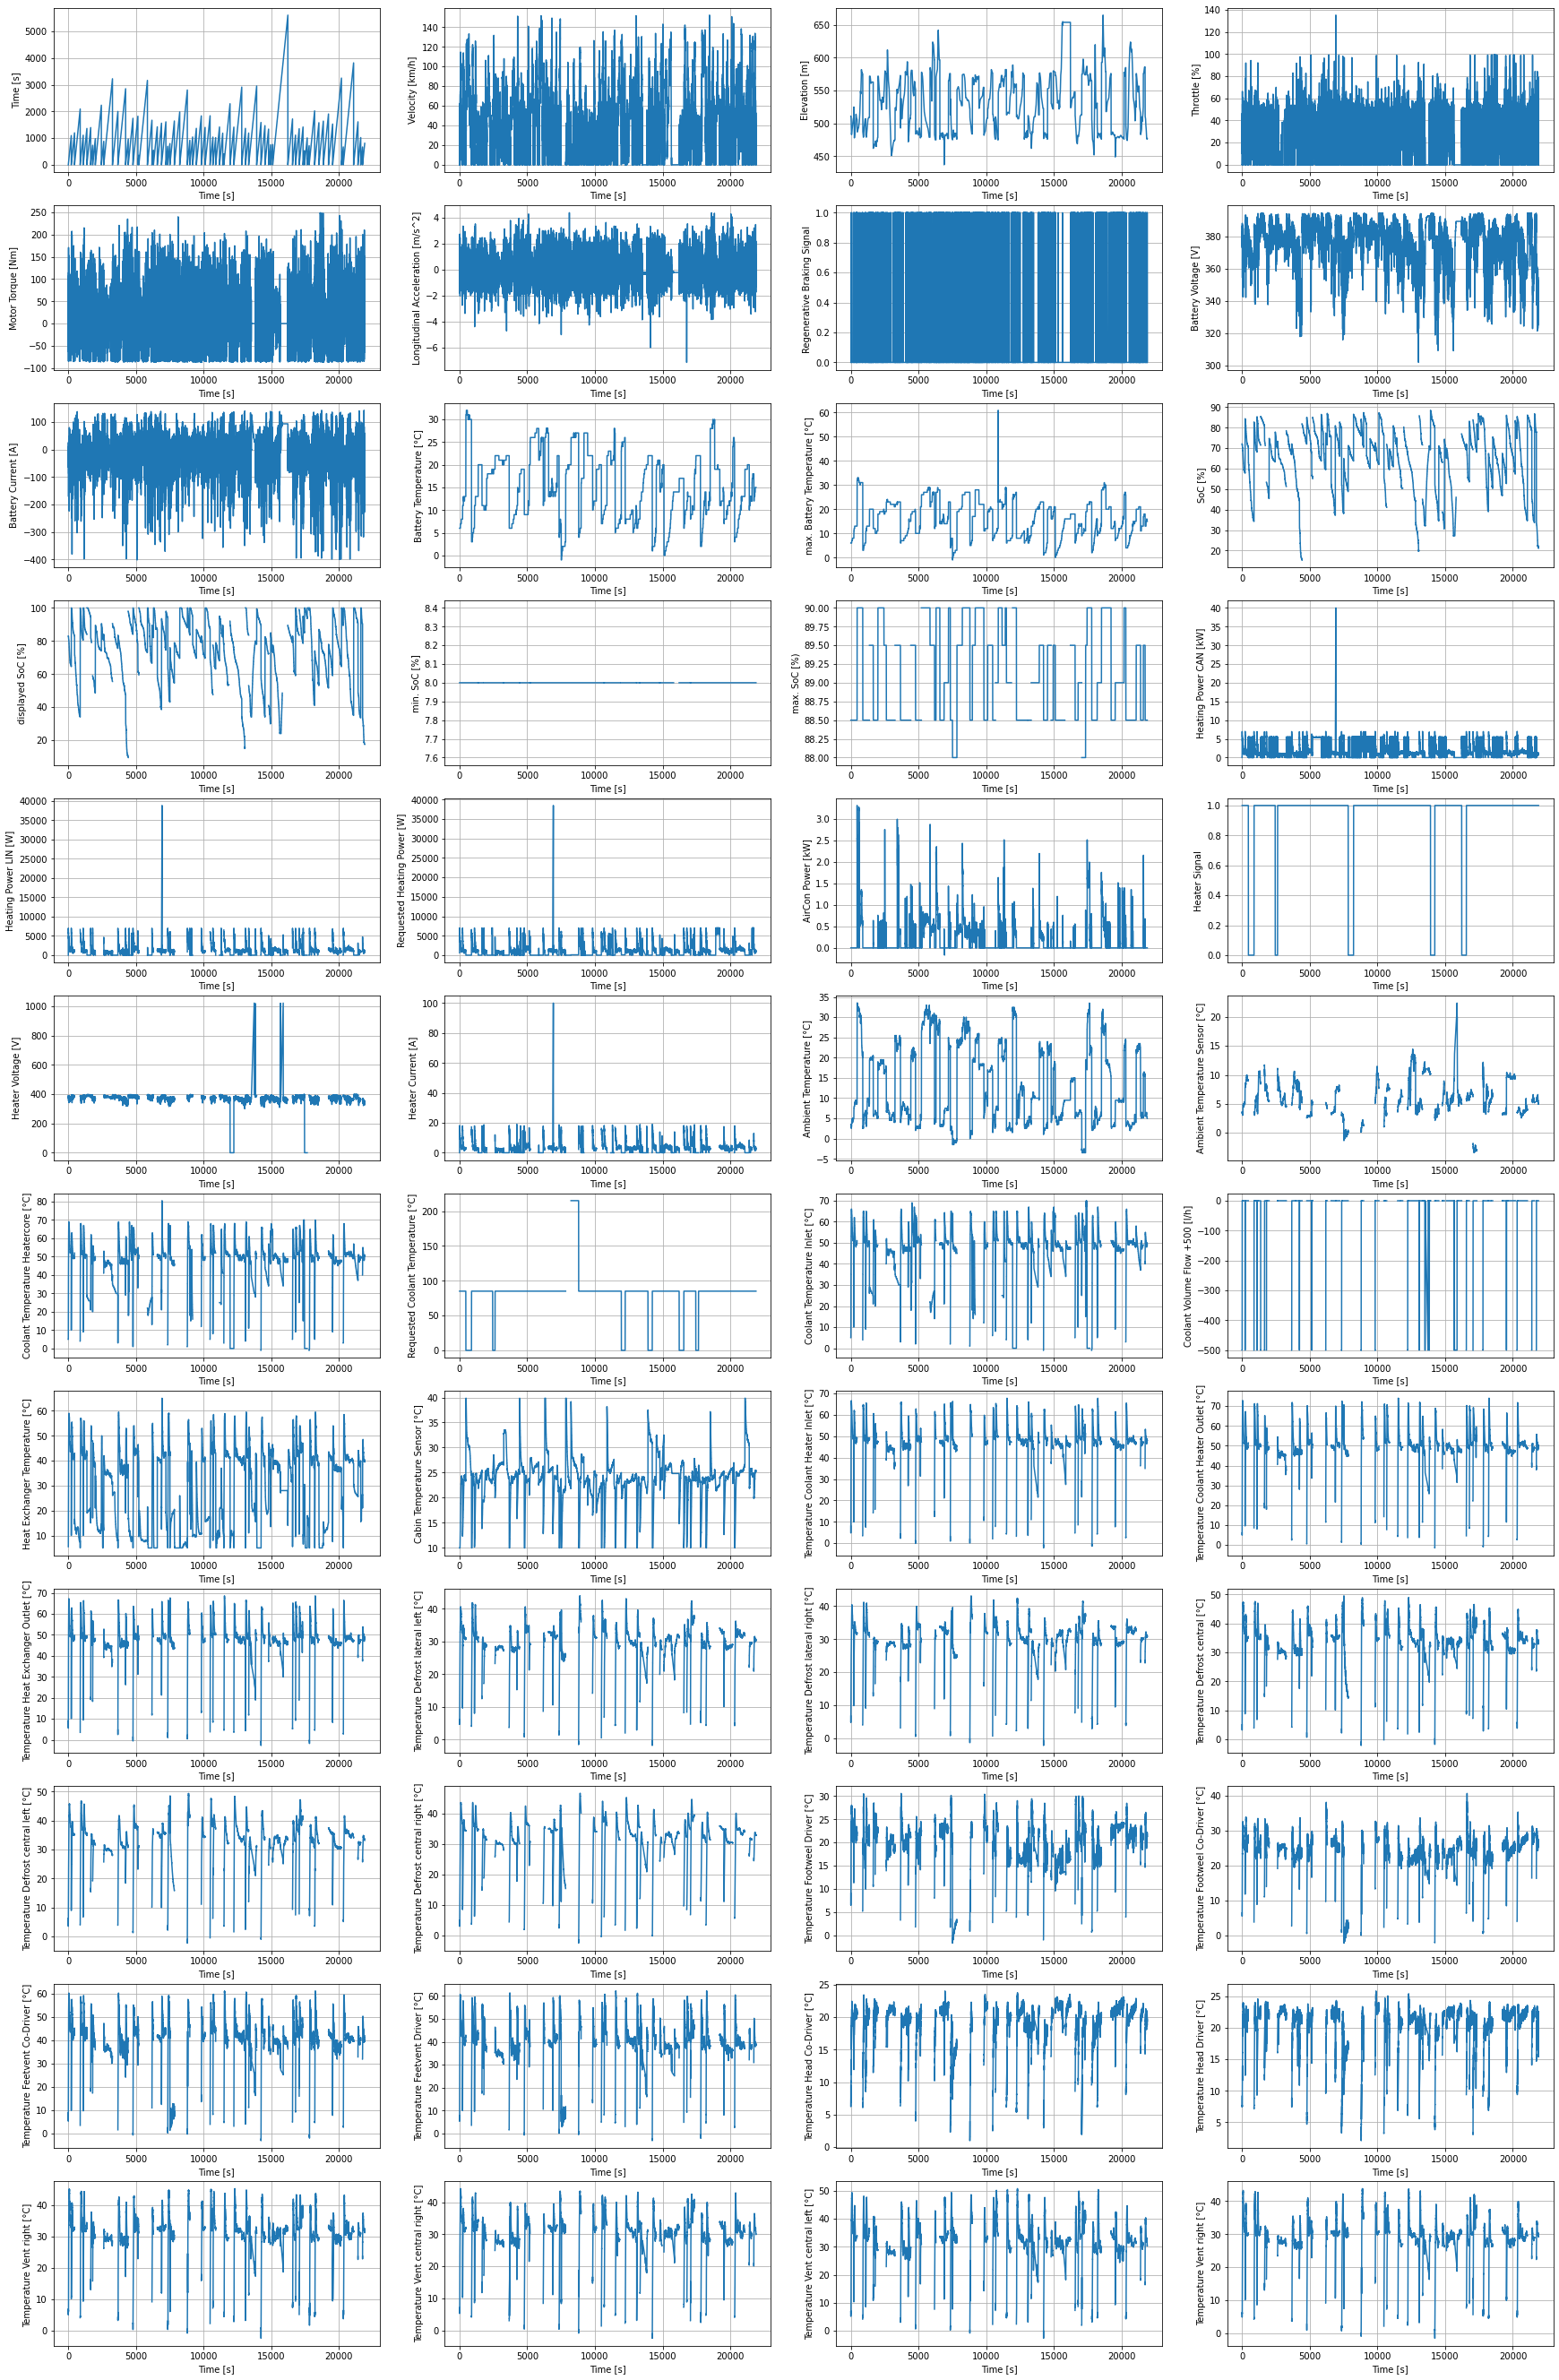

In [6]:
# Plot results of all trips
plot_dataframe_subplots(df_master, nrows=12, ncols=4, figsize=(30, 48))

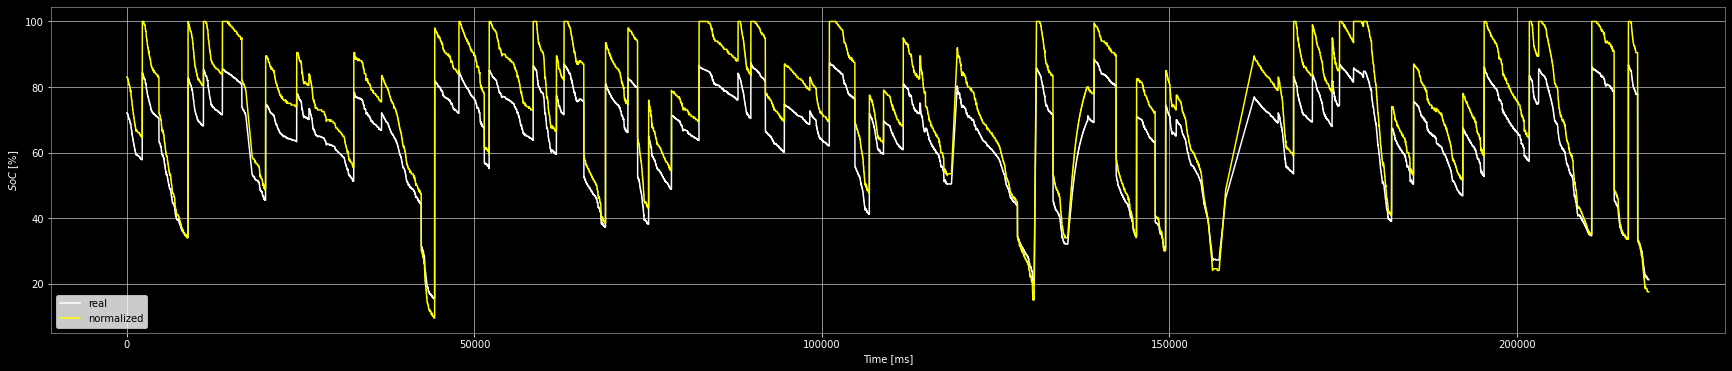

In [7]:
df_soc = df_master[['SoC [%]', 'displayed SoC [%]']].dropna()

# Let us look at battery SoC degradation over vehicle exploitation
plt.figure(figsize=(30, 6), facecolor='black')
ax = plt.axes()
ax.set_facecolor("black")
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.tick_params(colors='white', which='both')
plt.grid(True)

plt.plot(df_soc['SoC [%]'], color="white")
plt.plot(df_soc['displayed SoC [%]'], color="yellow")
plt.xlabel('Time [ms]', color='white')
plt.ylabel('$SoC$ [%]', color='white')
plt.legend(['real','normalized'])

<AxesSubplot:>

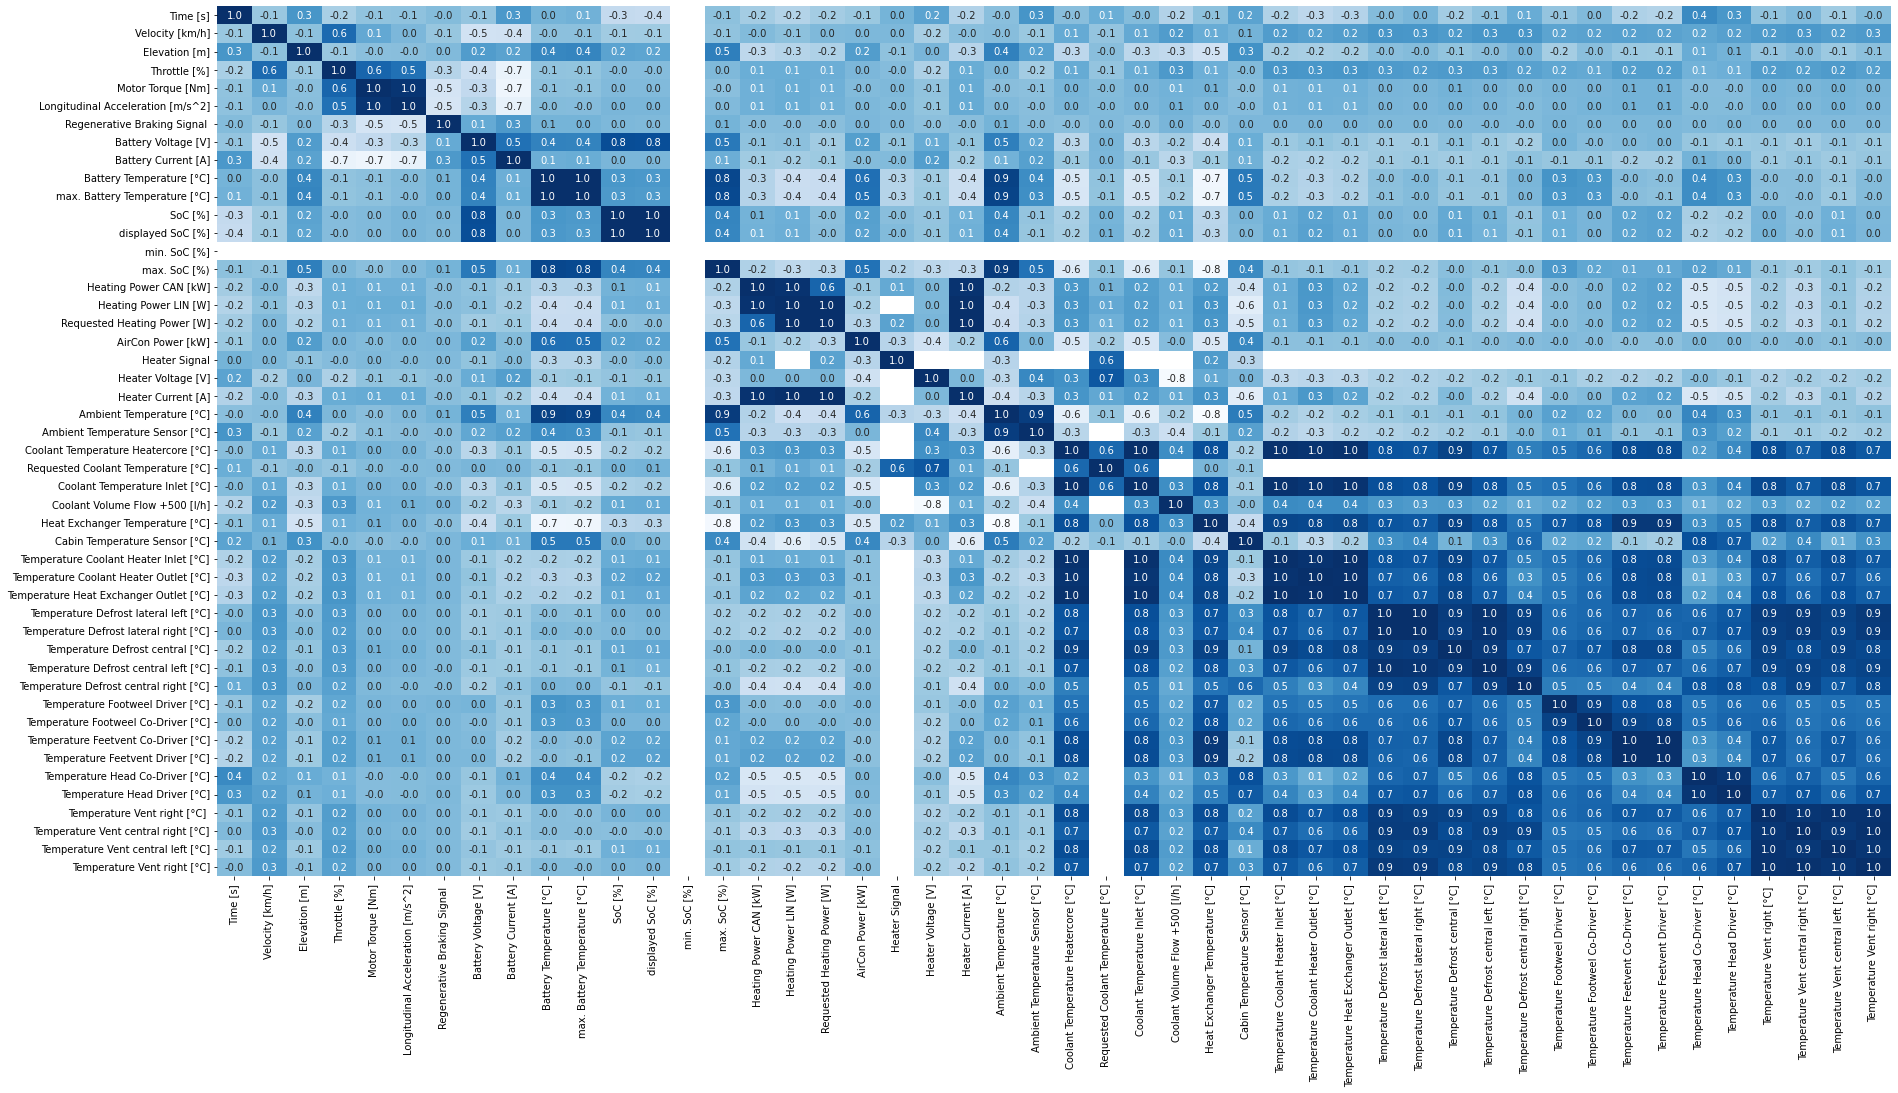

In [8]:
# Correlation between features
plt.figure(figsize=(30, 16))
seaborn.heatmap(df_master.corr(),annot=True, cbar=False, cmap='Blues', fmt='.1f')

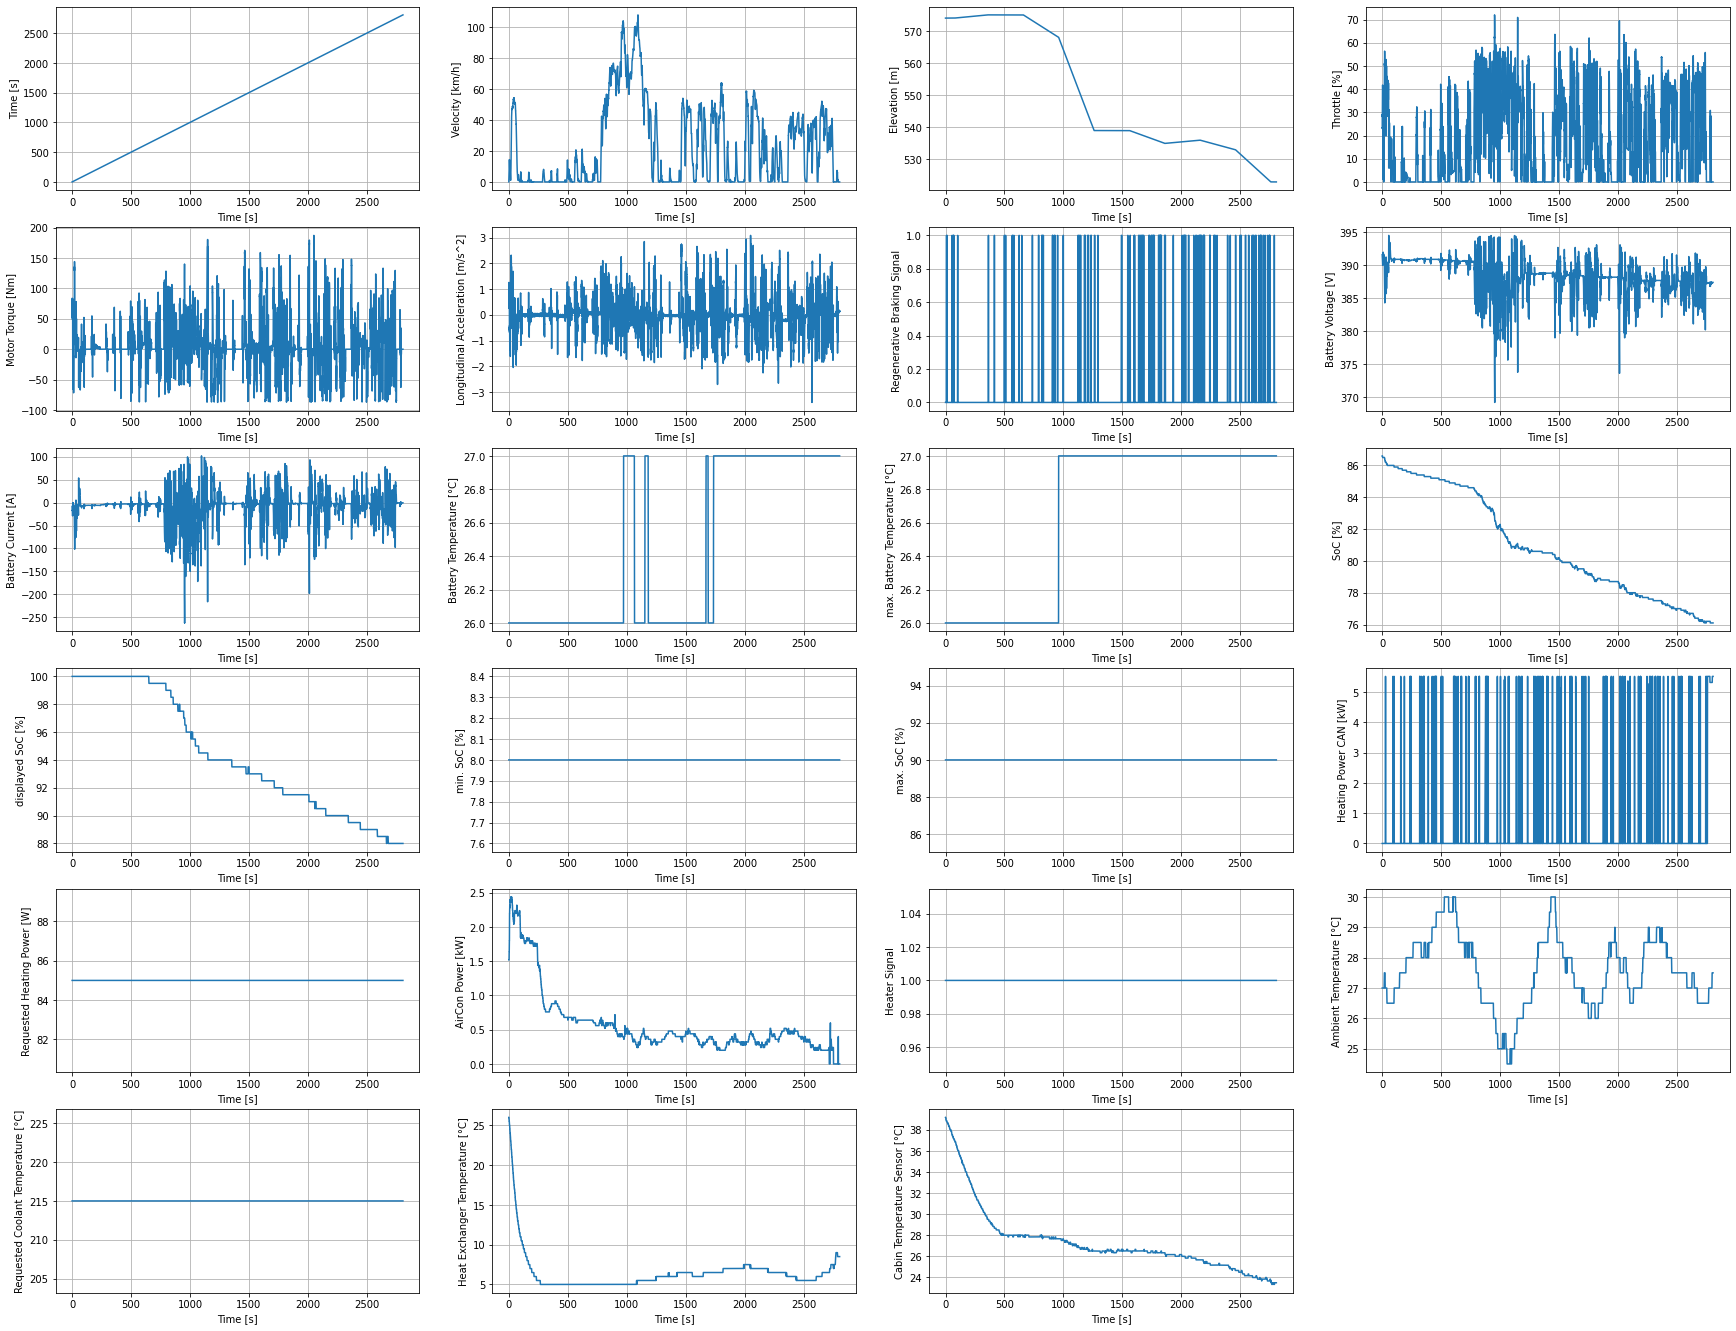

In [9]:
# Bring in a single trip as dataframe
df_trip = pd.read_csv(
    '../input/battery-and-heating-data-in-real-driving-cycles/TripA08.csv',
    sep=';',
    encoding=chardet.detect(open(f'../input/battery-and-heating-data-in-real-driving-cycles/TripA08.csv', 'rb').read())['encoding']
)
# Plot results of a single trips
plot_dataframe_subplots(df_trip, nrows=12, ncols=4, figsize=(30, 48))

<AxesSubplot:>

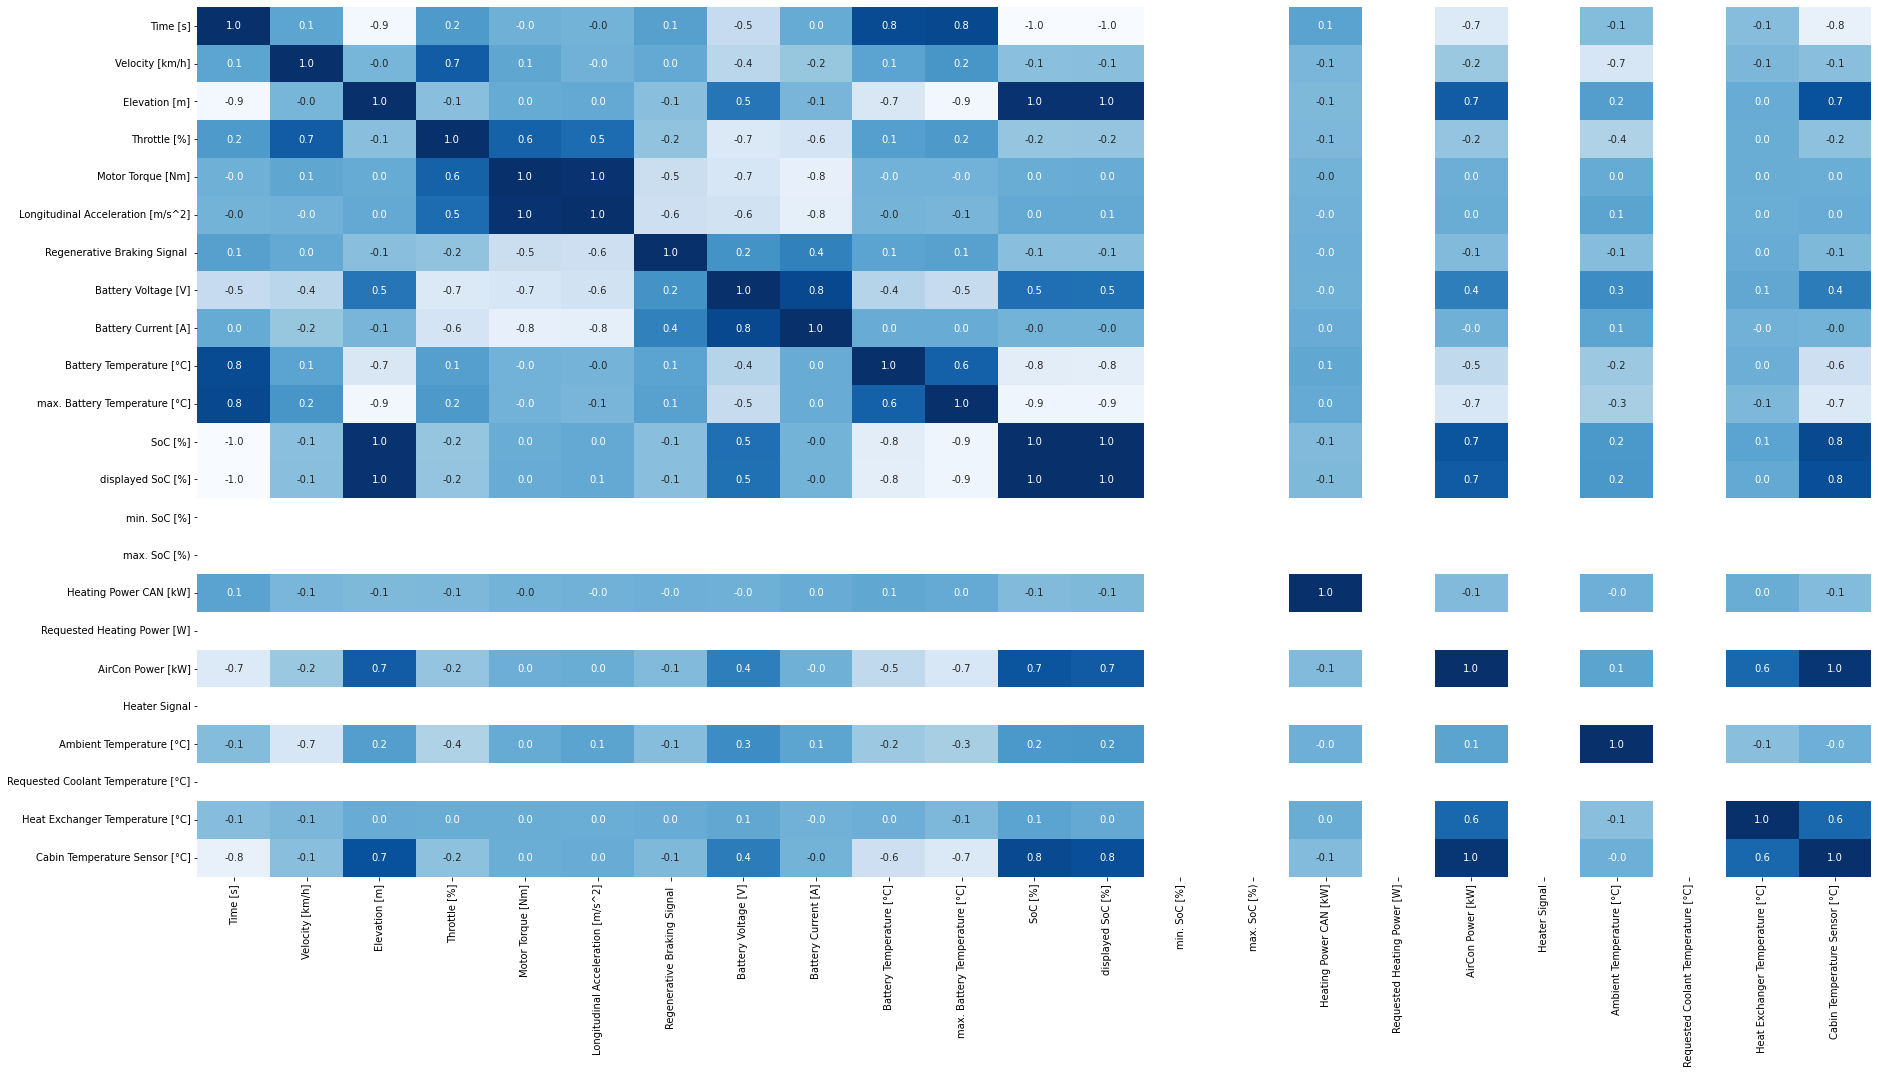

In [10]:
# Correlation between features
plt.figure(figsize=(30, 16))
seaborn.heatmap(df_trip.corr(),annot=True, cbar=False, cmap='Blues', fmt='.1f')

In [11]:
def set_negative_plot_color():
    plt.figure(figsize=(30, 6), facecolor='black')
    ax = plt.axes()
    ax.set_facecolor("black")
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.tick_params(colors='white', which='both')
    plt.grid(True)


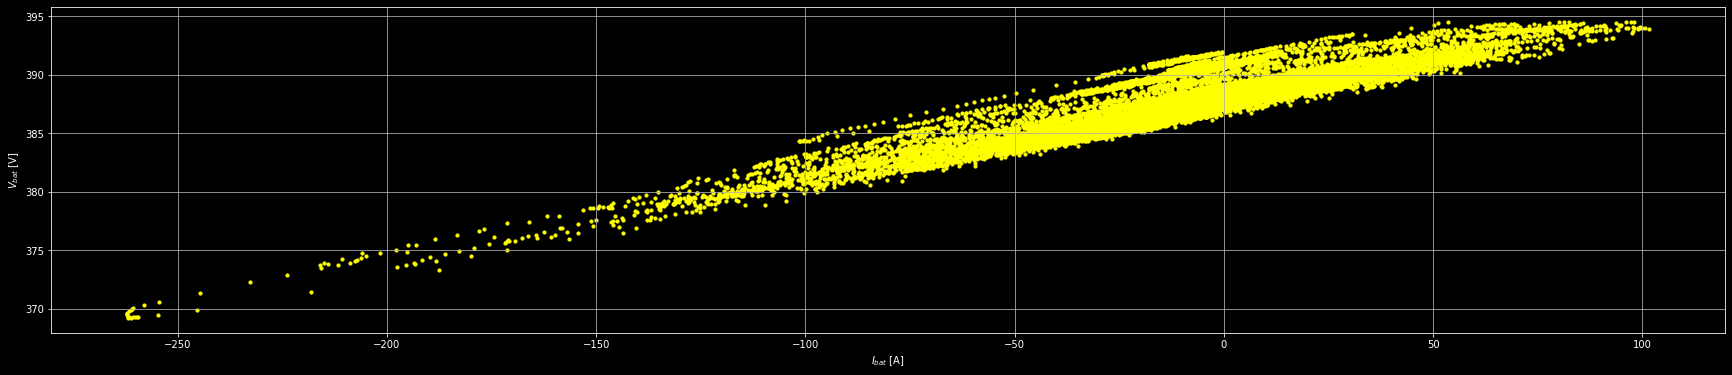

In [ ]:
set_negative_plot_color()
plt.scatter(df_trip['Battery Current [A]'], df_trip['Battery Voltage [V]'], color="yellow", s=10)
plt.xlabel('$I_{bat}$ [A]', color='white')
plt.ylabel('$V_{bat}$ [V]', color='white')

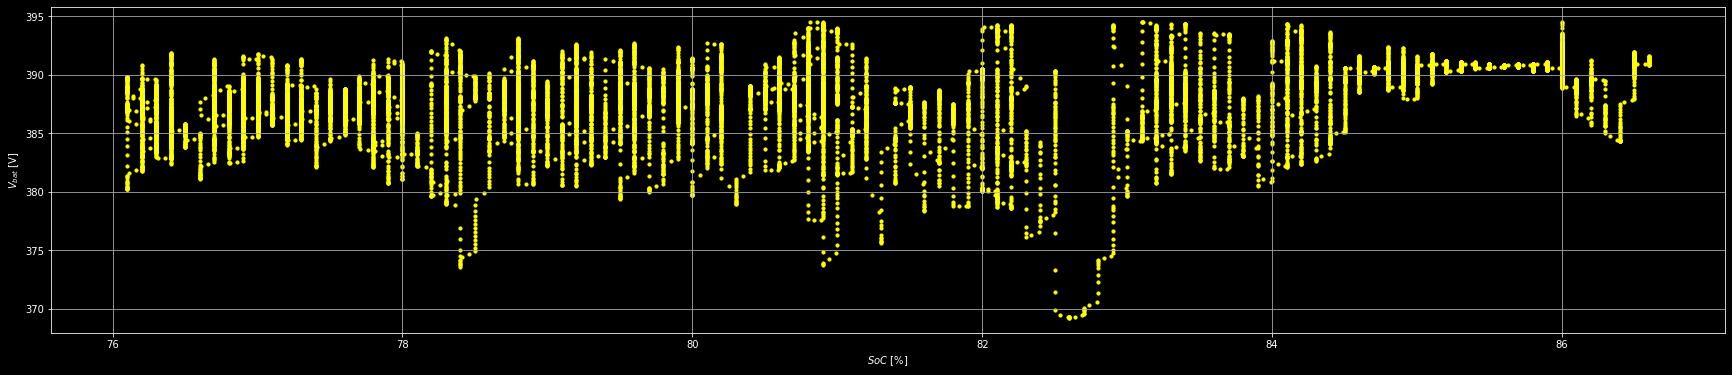

In [13]:
set_negative_plot_color()
plt.scatter(df_trip['SoC [%]'], df_trip['Battery Voltage [V]'], color="yellow", s=10)
plt.xlabel('$SoC$ [%]', color='white')
plt.ylabel('$V_{bat}$ [V]', color='white');

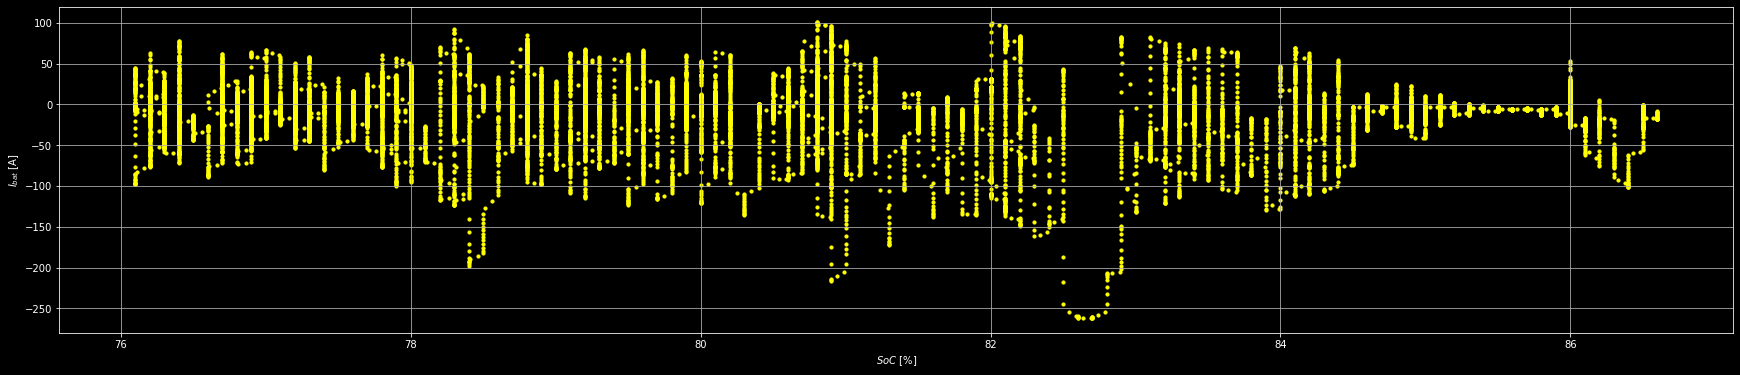

In [14]:
set_negative_plot_color()
plt.scatter(df_trip['SoC [%]'], df_trip['Battery Current [A]'], color="yellow", s=10)
plt.xlabel('$SoC$ [%]', color='white')
plt.ylabel('$I_{bat}$ [A]', color='white');

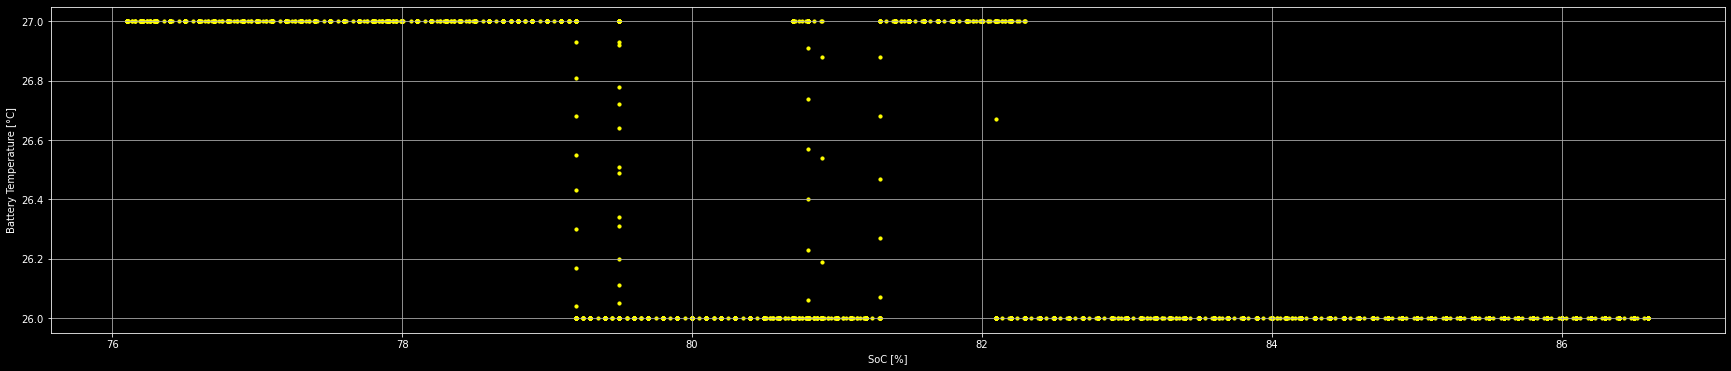

In [15]:
set_negative_plot_color()
plt.scatter(df_trip['SoC [%]'], df_trip['Battery Temperature [°C]'], color="yellow", s=10)
plt.xlabel('SoC [%]', color='white')
plt.ylabel('Battery Temperature [°C]', color='white');

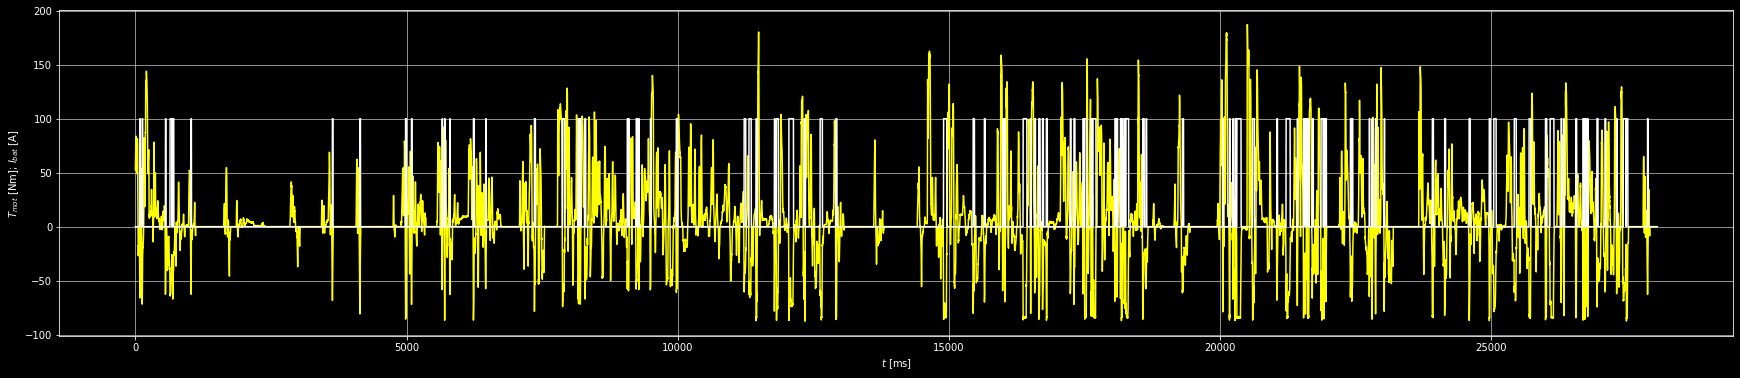

In [16]:
set_negative_plot_color()
plt.plot(df_trip['Motor Torque [Nm]'], color="yellow")
plt.plot(df_trip['Regenerative Braking Signal ']*100, color="white")
plt.xlabel('$t$ [ms]', color='white')
plt.ylabel('$T_{mot}$ [Nm]; $I_{bat}$ [A]', color='white');

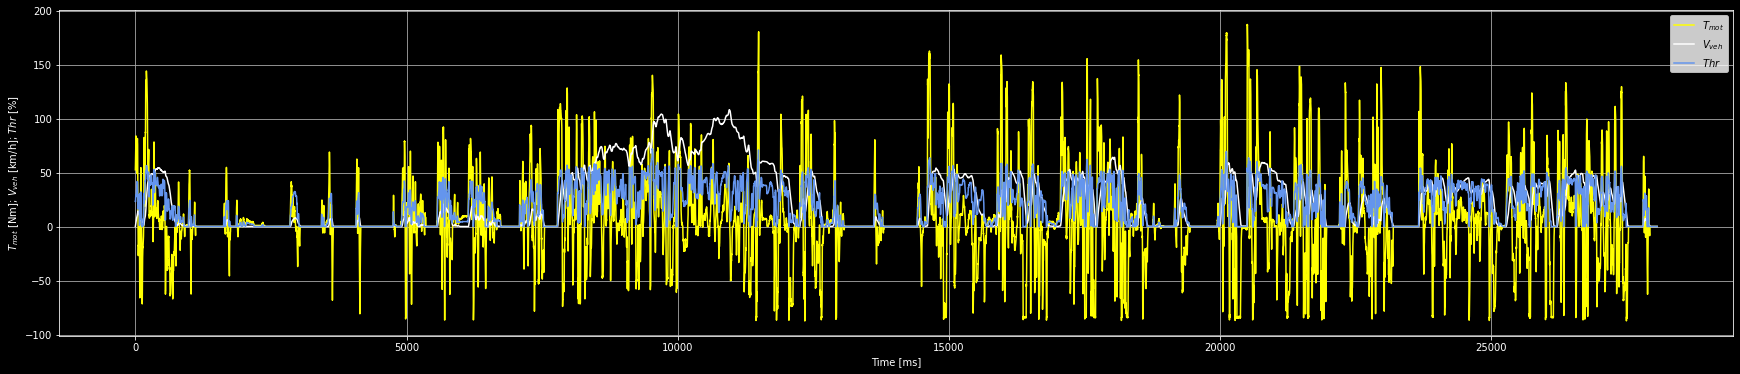

In [17]:
set_negative_plot_color()
plt.plot(df_trip['Motor Torque [Nm]'], color="yellow")
plt.plot(df_trip['Velocity [km/h]'], color="white")
plt.plot(df_trip['Throttle [%]'], color="cornflowerblue")
plt.xlabel('Time [ms]', color='white')
plt.ylabel('$T_{mot}$ [Nm]; $V_{veh}$ [km/h]; $Thr$ [%]', color='white')
plt.legend(['$T_{mot}$','$V_{veh}$','$Thr$']);

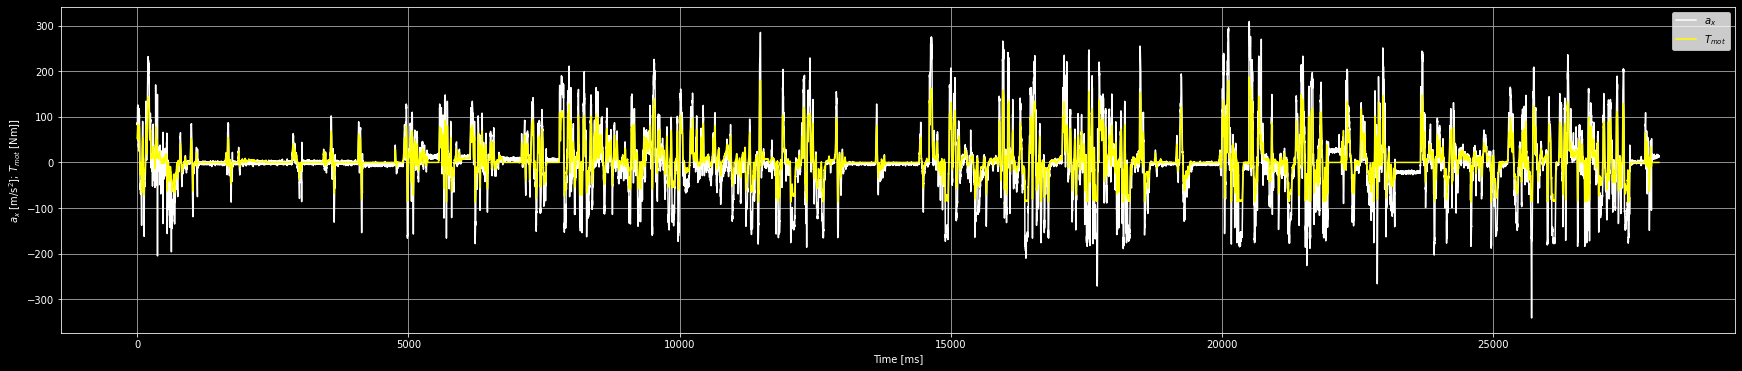

In [18]:
set_negative_plot_color()
plt.plot(df_trip['Longitudinal Acceleration [m/s^2]']*100, color="white")
plt.plot(df_trip['Motor Torque [Nm]'], color="yellow")
plt.xlabel('Time [ms]', color='white')
plt.ylabel('$a_{x}$ [m/s$^{2}]$; $T_{mot}$ [Nm]]', color='white')
plt.legend(['$a_{x}$','$T_{mot}$']);

In [19]:
def regression_matrics(y_test, y_pred):
    # calculate errors
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    # report error
    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Square Error: {rmse}')
    print(f'Mean Absolute Error: {mae}')


def plot_comparison(y_test, y_pred, xlabel, ylabel, dark_mode=False, figsize=(30, 6)):
    if dark_mode:
        plt.figure(figsize=figsize, facecolor='black')
        ax = plt.axes()
        ax.set_facecolor("black")
        ax.spines['bottom'].set_color('gray')
        ax.spines['top'].set_color('gray')
        ax.spines['right'].set_color('gray')
        ax.spines['left'].set_color('gray')
        ax.tick_params(colors='white', which='both')
        plt.plot(y_pred, color="yellow")
        plt.plot(y_test, color="white")
        plt.legend(['Predicted', 'Measured'])
        plt.xlabel(xlabel, color='white')
        plt.ylabel(ylabel, color='white')
    else:
        plt.figure(figsize=figsize)
        plt.plot(y_pred)
        plt.plot(y_test)
        plt.legend(['Predicted', 'Measured'])
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    plt.grid(True)

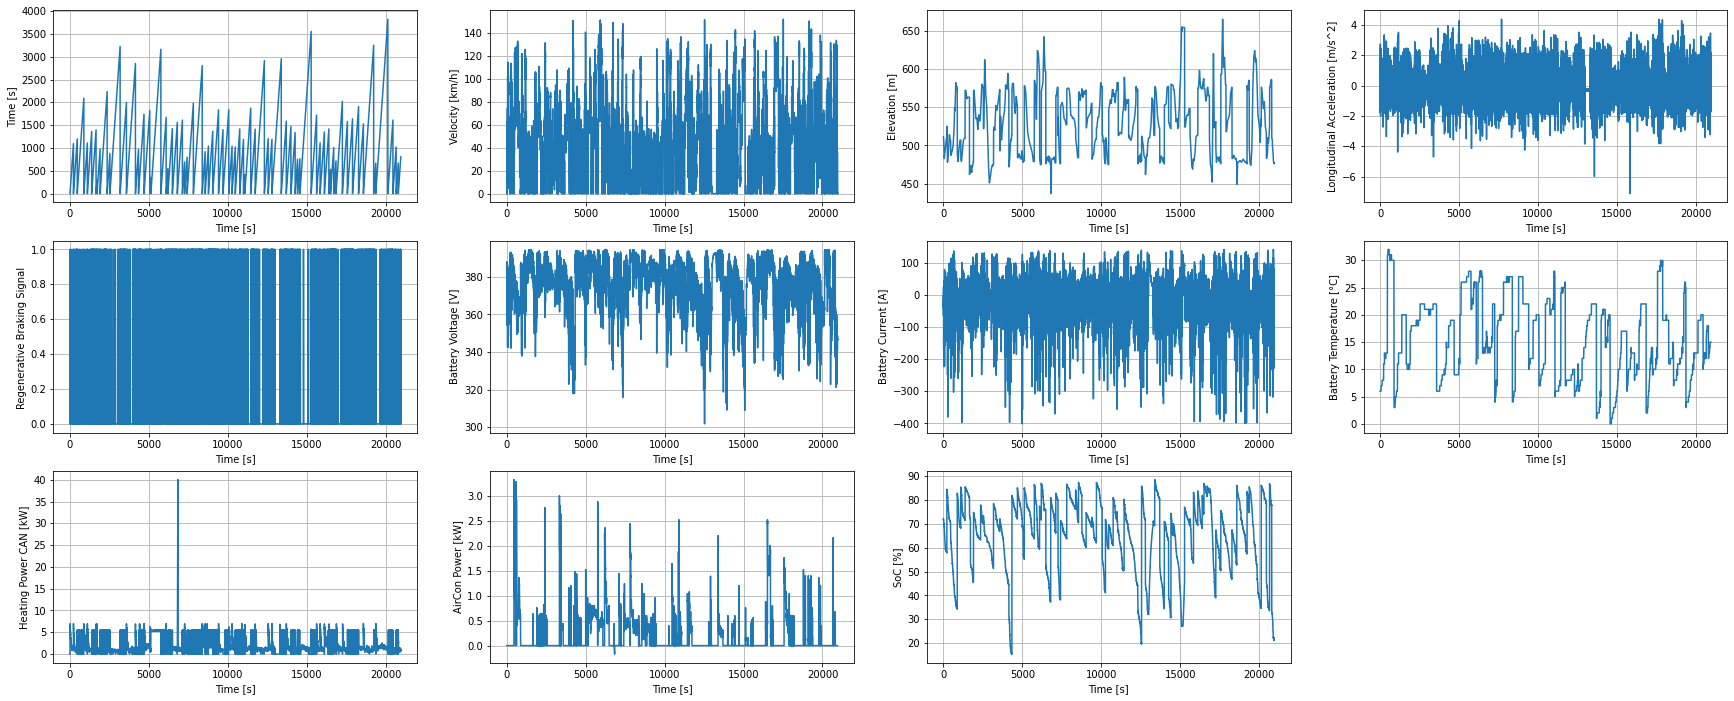

In [20]:
df_x_y = df_master[['Time [s]','Velocity [km/h]','Elevation [m]','Longitudinal Acceleration [m/s^2]','Regenerative Braking Signal ','Battery Voltage [V]',
                    'Battery Current [A]','Battery Temperature [°C]','Heating Power CAN [kW]','AirCon Power [kW]','SoC [%]']].dropna()

plot_dataframe_subplots(df_x_y, nrows=3, ncols=4, figsize=(30, 12))

In [21]:
# Create and split train and test datasets
X = df_x_y.drop(['Time [s]','SoC [%]'], axis=1)
y = df_x_y[['SoC [%]']]
splitter = int(len(X)*0.7)
X_train = X.values[:splitter]
X_test = X.values[splitter:]
y_train = y.values[:splitter]
y_test = y.values[splitter:]
# Check the dataset sizes
X_train.shape, y_train.shape, X_test.shape, y_test.shape[0]

((146677, 9), (146677, 1), (62862, 9), 62862)

Linear Regression:
Mean Squared Error: 25.36433115580778
Root Mean Square Error: 5.036301336874888
Mean Absolute Error: 3.4706140476439407


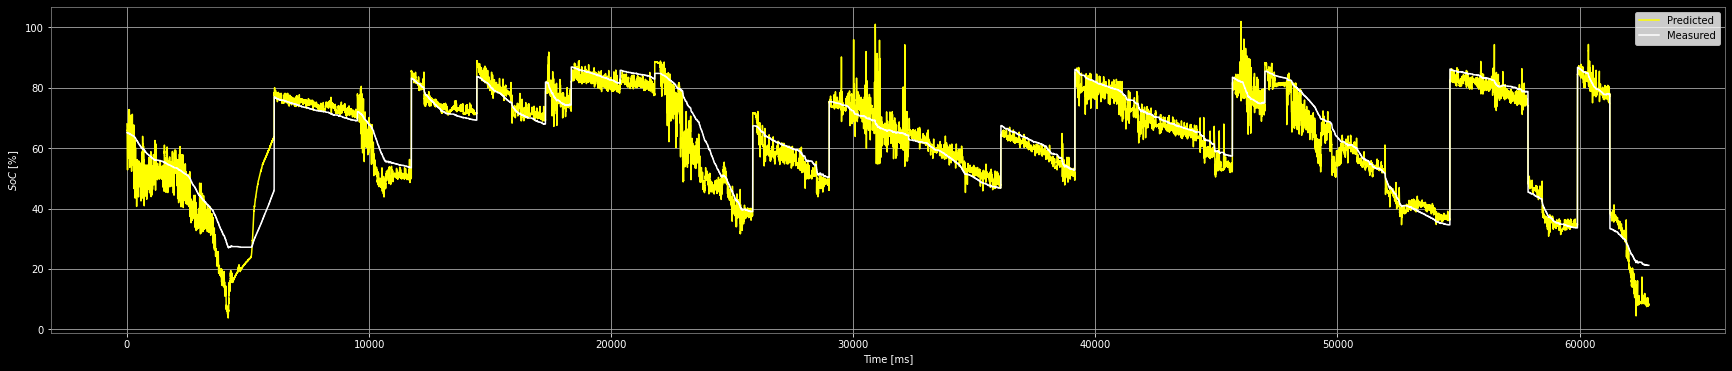

In [22]:
# 1. Create a model
regressor = LinearRegression()
# 2. Fit the model
regressor.fit(X_train, y_train)
# 3. Make predicitons with the model
y_pred_lr = regressor.predict(X_test)
# 4. Evaluate and visualize
print('Linear Regression:')
regression_matrics(y_test, y_pred_lr)
plot_comparison(y_test=y_test, y_pred=y_pred_lr, xlabel="Time [ms]", ylabel="$SoC$ [%]", dark_mode=True)

Neural Network:
Mean Squared Error: 167.74460820933166
Root Mean Square Error: 12.951625697545913
Mean Absolute Error: 10.521454796315133


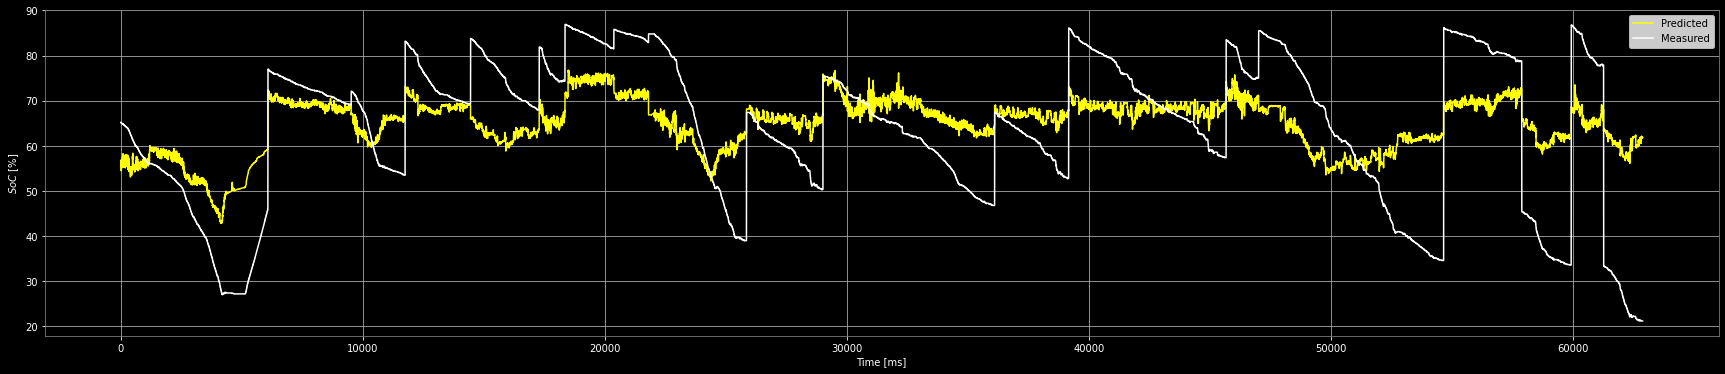

In [23]:
# 1. Create a model
regressor = Sequential([
    layers.Dense(10),
    layers.Dense(10),
    layers.Dense(1),
])
# 2. Compile a model
regressor.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss=losses.mae,
                  metrics=["mae"])
# 3. Fit a model
regressor.fit(X_train, y_train, epochs=10, verbose=0)
# 4. Validate the model
y_pred_nn = regressor.predict(X_test)
# 5. Evaluate and visualize
print('Neural Network:')
regression_matrics(y_test, y_pred_nn)
plot_comparison(y_test=y_test, y_pred=y_pred_nn, xlabel="Time [ms]", ylabel="$SoC$ [%]", dark_mode=True)

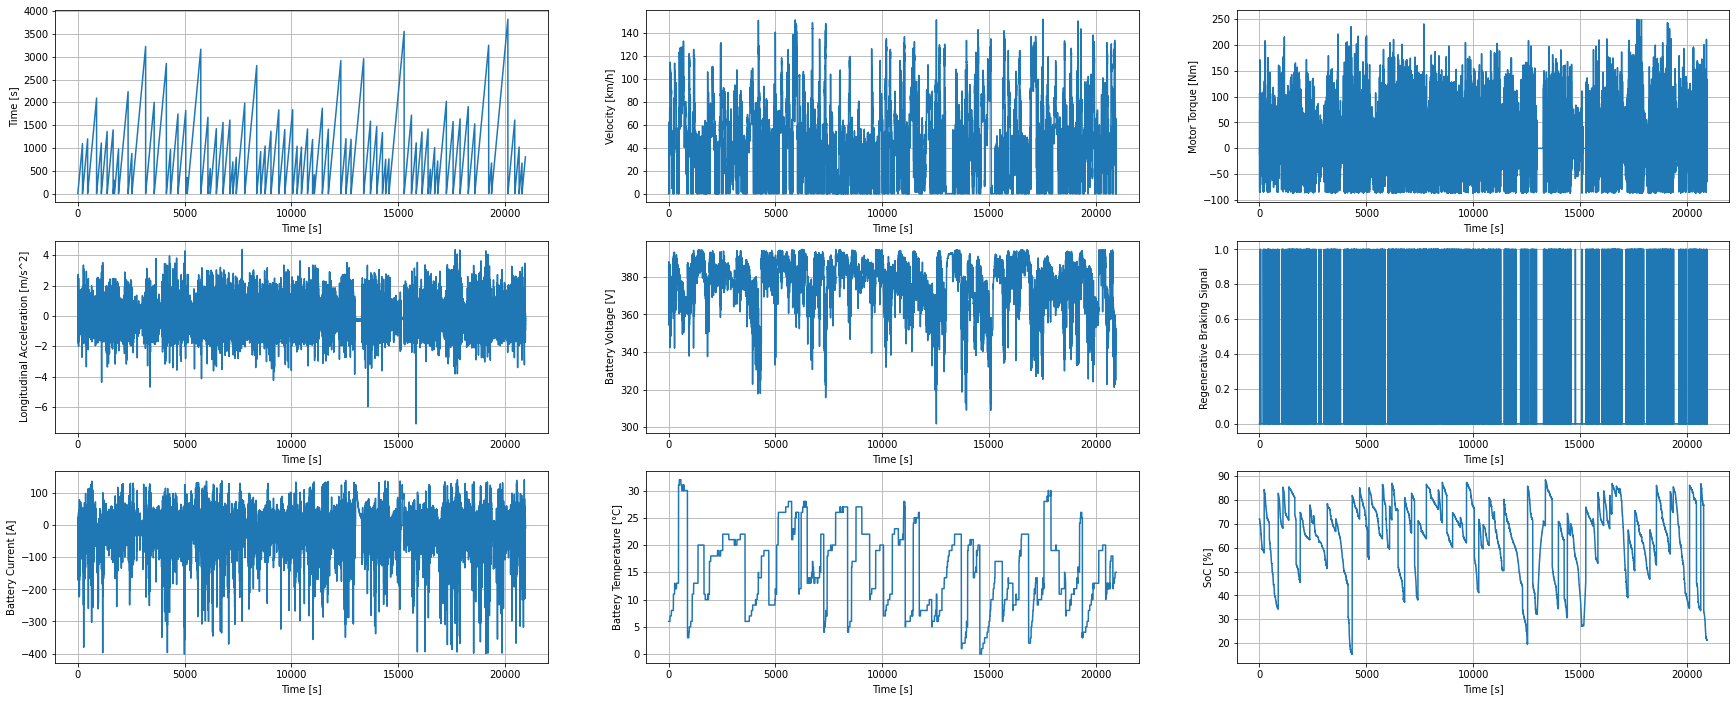

In [24]:
df_x_y = df_master[['Time [s]','Velocity [km/h]','Motor Torque [Nm]','Longitudinal Acceleration [m/s^2]','Battery Voltage [V]','Regenerative Braking Signal ',
                    'Battery Current [A]','Battery Temperature [°C]','SoC [%]']].dropna()

plot_dataframe_subplots(df_x_y, nrows=3, ncols=3, figsize=(30, 12))

In [25]:
df_x_y = df_master[['Elevation [m]','Motor Torque [Nm]','Battery Voltage [V]','Battery Current [A]','SoC [%]','Heating Power CAN [kW]', 'Heating Power LIN [W]',
                    'Requested Heating Power [W]', 'AirCon Power [kW]','Heater Signal', 'Heater Current [A]','Ambient Temperature [°C]','Coolant Temperature Heatercore [°C]',
                    'Coolant Temperature Inlet [°C]','Heat Exchanger Temperature [°C]','Cabin Temperature Sensor [°C]','Temperature Coolant Heater Inlet [°C]',
                    'Temperature Coolant Heater Outlet [°C]','Temperature Heat Exchanger Outlet [°C]','Temperature Footweel Driver [°C]','Temperature Footweel Co-Driver [°C]',
                    'Temperature Head Co-Driver [°C]','Temperature Head Driver [°C]','Battery Temperature [°C]']].dropna()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            28672     
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 64)            256       
_________________________________________________________________
dropout (Dropout)            (None, 10, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)               

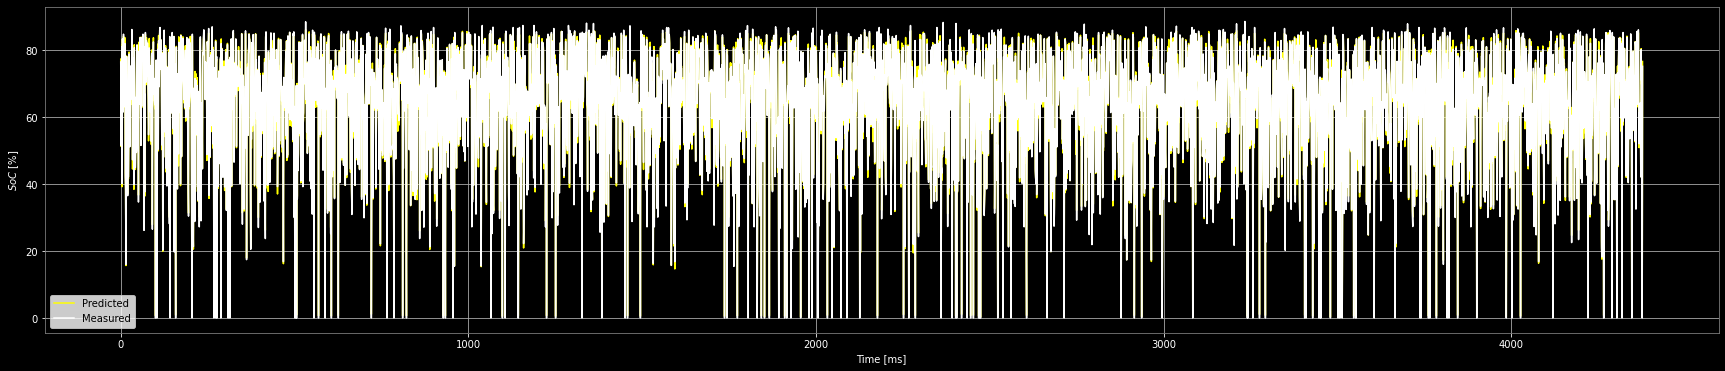

In [26]:
import numpy as np
import pandas as pd
from tensorflow.keras import Sequential, layers, optimizers, losses, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming df_master is your loaded dataframe
target_col = 'SoC [%]'
feature_cols = [col for col in df_master.columns if col != target_col]

# Prepare features and target arrays
X = df_master[feature_cols].values
y = df_master[target_col].values.reshape(-1, 1)  # reshape for scaler

# Handle NaNs early (simple fill)
X = np.nan_to_num(X)
y = np.nan_to_num(y)

# Scale features and target
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y)

# Split into train and test sets (do before sequence creation)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42)

# Use longer sequences, e.g., 10 timesteps
timesteps = 10
features = X_train.shape[1]

# Check if total samples divisible by timesteps for reshaping
def create_sequences(X, y, timesteps):
    samples = X.shape[0] // timesteps
    X = X[:samples * timesteps].reshape(samples, timesteps, features)
    y = y[:samples * timesteps].reshape(samples, timesteps, 1)
    # For prediction, you usually take last timestep output
    y = y[:, -1, 0]
    return X, y

X_train_seq, y_train_seq = create_sequences(X_train, y_train, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, timesteps)

# Build the LSTM model with BatchNorm
regressor = Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(timesteps, features)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.LSTM(32),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

# Model summary
regressor.summary()

regressor.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.MeanSquaredError(),  # switch to MSE
    metrics=["mae"]
)

# Early stopping to avoid overfitting
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
regressor.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Predict and inverse scale the outputs
y_pred_scaled = regressor.predict(X_test_seq)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_true = target_scaler.inverse_transform(y_test_seq.reshape(-1,1))

# Evaluate ignoring NaNs (unlikely here after scaling)
mask = ~np.isnan(y_true).flatten() & ~np.isnan(y_pred).flatten()
y_true_clean = y_true[mask].flatten()
y_pred_clean = y_pred[mask].flatten()

print("LSTM Model evaluation:")
regression_matrics(y_true_clean, y_pred_clean)
plot_comparison(
    y_test=y_true_clean,
    y_pred=y_pred_clean,
    xlabel="Time [ms]",
    ylabel="$SoC$ [%]",
    dark_mode=True
)




Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 20, 256)           180224    
_________________________________________________________________
batch_normalization_2 (Batch (None, 20, 256)           1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20, 128)           164352    
_________________________________________________________________
batch_normalization_3 (Batch (None, 20, 128)           512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)               

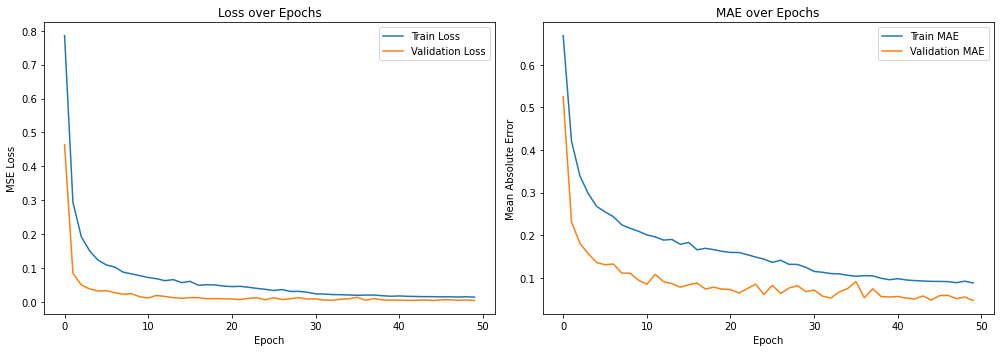

BiLSTM Model evaluation:
Mean Squared Error: 1.1998257374856145
Root Mean Square Error: 1.0953655725307485
Mean Absolute Error: 0.8333133677479904


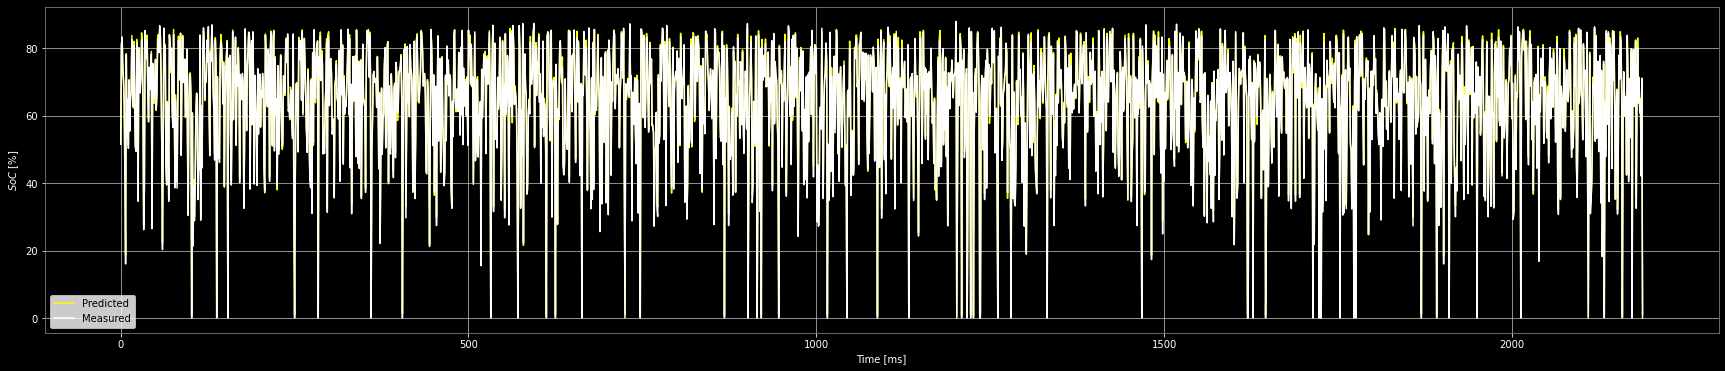

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, layers, optimizers, losses, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming df_master is your loaded dataframe
target_col = 'SoC [%]'
feature_cols = [col for col in df_master.columns if col != target_col]

# Prepare features and target arrays
X = df_master[feature_cols].values
y = df_master[target_col].values.reshape(-1, 1)

# Handle NaNs
X = np.nan_to_num(X)
y = np.nan_to_num(y)

# Scale
feature_scaler = StandardScaler()
target_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42)

# Sequences
timesteps = 20
features = X_train.shape[1]

def create_sequences(X, y, timesteps):
    samples = X.shape[0] // timesteps
    X_seq = X[:samples * timesteps].reshape(samples, timesteps, features)
    y_seq = y[:samples * timesteps].reshape(samples, timesteps, 1)
    return X_seq, y_seq[:, -1, 0]

X_train_seq, y_train_seq = create_sequences(X_train, y_train, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, timesteps)

# Model
regressor = Sequential([
    layers.Bidirectional(layers.LSTM(128, return_sequences=True), input_shape=(timesteps, features)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Bidirectional(layers.LSTM(32)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

regressor.summary()

regressor.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.MeanSquaredError(),
    metrics=["mae"]
)

# Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

# Train
history = regressor.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Plot curves
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.tight_layout()
plt.show()

# Predict
y_pred_scaled = regressor.predict(X_test_seq)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_true = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1))

# Clean results
mask = ~np.isnan(y_true).flatten() & ~np.isnan(y_pred).flatten()
y_true_clean = y_true[mask].flatten()
y_pred_clean = y_pred[mask].flatten()

# Evaluate
print("BiLSTM Model evaluation:")
regression_matrics(y_true_clean, y_pred_clean)
plot_comparison(
    y_test=y_true_clean,
    y_pred=y_pred_clean,
    xlabel="Time [ms]",
    ylabel="$SoC$ [%]",
    dark_mode=True
)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 20, 128)           43392     
_________________________________________________________________
batch_normalization_5 (Batch (None, 20, 128)           512       
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                31104     
_________________________________________________________________
batch_normalization_6 (Batch (None, 64)                256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)               

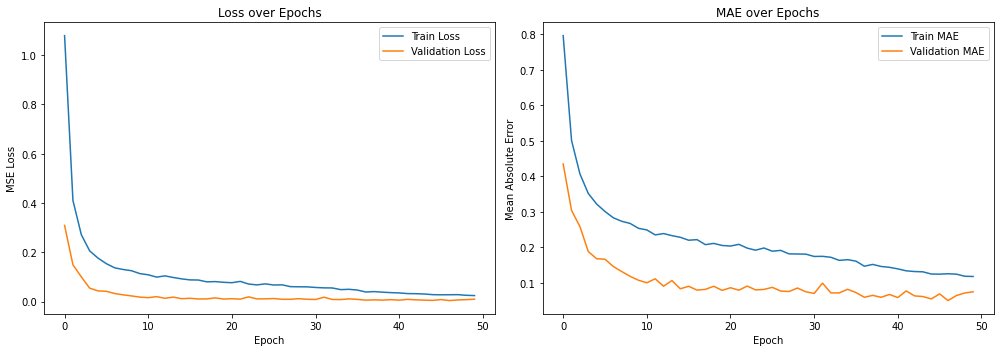

GRU Model evaluation:
Mean Squared Error: 3.084655960529366
Root Mean Square Error: 1.756318866416166
Mean Absolute Error: 1.3548112516469595


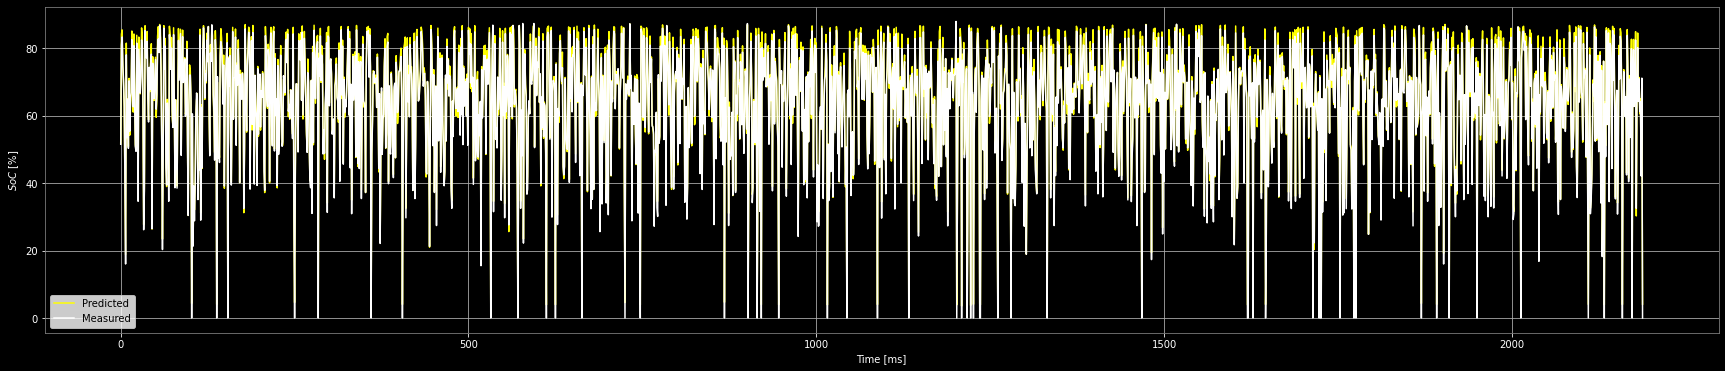

In [28]:
import numpy as np
import pandas as pd
import os, datetime
from tensorflow.keras import Sequential, layers, optimizers, losses, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Target and features
target_col = 'SoC [%]'
feature_cols = [col for col in df_master.columns if col != target_col]

X = df_master[feature_cols].values
y = df_master[target_col].values.reshape(-1, 1)

# Handle NaNs and scale
X = np.nan_to_num(X)
y = np.nan_to_num(y)

feature_scaler = StandardScaler()
target_scaler = StandardScaler()

X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42)

# Sequence creation
timesteps = 20
features = X_train.shape[1]

def create_sequences(X, y, timesteps):
    samples = X.shape[0] // timesteps
    X_seq = X[:samples * timesteps].reshape(samples, timesteps, features)
    y_seq = y[:samples * timesteps].reshape(samples, timesteps, 1)
    return X_seq, y_seq[:, -1, 0]

X_train_seq, y_train_seq = create_sequences(X_train, y_train, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, timesteps)

# 📁 TensorBoard logs directory
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ⚙️ GRU model
regressor = Sequential([
    layers.Bidirectional(layers.GRU(64, return_sequences=True), input_shape=(timesteps, features)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Bidirectional(layers.GRU(32)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])
# Model summary
regressor.summary()

regressor.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.MeanSquaredError(),
    metrics=["mae"]
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


# 🧠 Train with TensorBoard
history = regressor.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, tensorboard_callback],
    verbose=1
)

# 📊 Visualisation des courbes d'entraînement
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

# 🔍 Evaluate
y_pred_scaled = regressor.predict(X_test_seq)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_true = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1))

mask = ~np.isnan(y_true).flatten() & ~np.isnan(y_pred).flatten()
y_true_clean = y_true[mask].flatten()
y_pred_clean = y_pred[mask].flatten()

print("GRU Model evaluation:")
regression_matrics(y_true_clean, y_pred_clean)
plot_comparison(
    y_test=y_true_clean,
    y_pred=y_pred_clean,
    xlabel="Time [ms]",
    ylabel="$SoC$ [%]",
    dark_mode=True
)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 20, 64)            9088      
_________________________________________________________________
batch_normalization_7 (Batch (None, 20, 64)            256       
_________________________________________________________________
dropout_7 (Dropout)          (None, 20, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 64)            12352     
_________________________________________________________________
batch_normalization_8 (Batch (None, 20, 64)            256       
_________________________________________________________________
dropout_8 (Dropout)          (None, 20, 64)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 20, 128)          

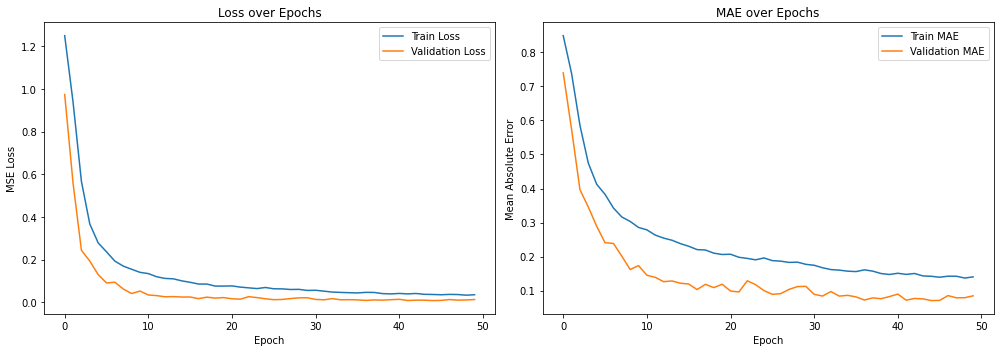

Hybrid CNN-LSTM Model evaluation:
Mean Squared Error: 3.6614601978468473
Root Mean Square Error: 1.91349423773547
Mean Absolute Error: 1.460591261152962


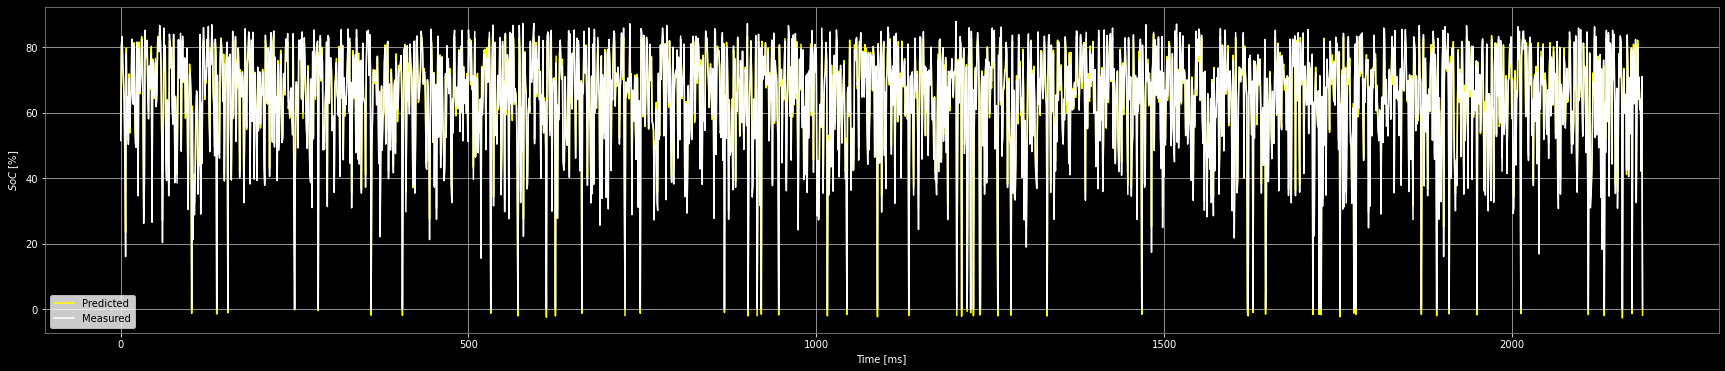

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, layers, optimizers, losses, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming df_master is your loaded dataframe
target_col = 'SoC [%]'
feature_cols = [col for col in df_master.columns if col != target_col]

# Prepare features and target arrays
X = df_master[feature_cols].values
y = df_master[target_col].values.reshape(-1, 1)

# Handle NaNs
X = np.nan_to_num(X)
y = np.nan_to_num(y)

# Scale features and target
feature_scaler = StandardScaler()
target_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42)

# Create sequences
timesteps = 20
features = X_train.shape[1]

def create_sequences(X, y, timesteps):
    samples = X.shape[0] // timesteps
    X_seq = X[:samples * timesteps].reshape(samples, timesteps, features)
    y_seq = y[:samples * timesteps].reshape(samples, timesteps, 1)
    return X_seq, y_seq[:, -1, 0]

X_train_seq, y_train_seq = create_sequences(X_train, y_train, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, timesteps)

# Build hybrid CNN-RNN model
regressor = Sequential([
    # 1D Conv layers to extract local temporal features
    layers.Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu', input_shape=(timesteps, features)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # RNN layers for sequence modeling
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Bidirectional(layers.LSTM(32)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Dense layers for regression output
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

regressor.summary()

regressor.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.MeanSquaredError(),
    metrics=["mae"]
)

# Callbacks for training
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

# Train the model
history = regressor.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Plot training curves
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.tight_layout()
plt.show()

# Predict and inverse scale
y_pred_scaled = regressor.predict(X_test_seq)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_true = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1))

# Clean NaNs if any
mask = ~np.isnan(y_true).flatten() & ~np.isnan(y_pred).flatten()
y_true_clean = y_true[mask].flatten()
y_pred_clean = y_pred[mask].flatten()

# Evaluation and plotting (assuming you have these functions)
print("Hybrid CNN-LSTM Model evaluation:")
regression_matrics(y_true_clean, y_pred_clean)
plot_comparison(
    y_test=y_true_clean,
    y_pred=y_pred_clean,
    xlabel="Time [ms]",
    ylabel="$SoC$ [%]",
    dark_mode=True
)


Temporal Convolutional Network

Your data has temporal structure (like time series, sensor data, audio).

You want faster training than LSTM/GRU.

You want to process many sequences at once (better for GPUs).

You don’t want to deal with recurrent states.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 47)]     0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 20, 64)       9088        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 20, 64)       256         conv1d_2[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 20, 64)       0           batch_normalization_11[0][0]     
______________________________________________________________________________________________

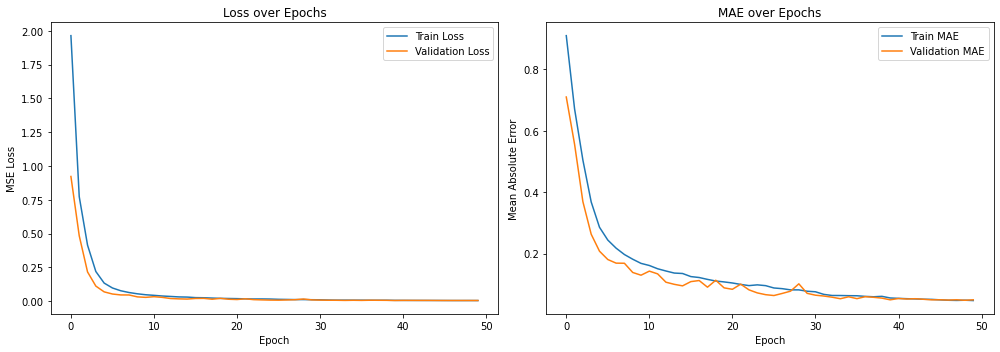

TCN Model evaluation:
Mean Squared Error: 1.287673415874624
Root Mean Square Error: 1.1347569853826078
Mean Absolute Error: 0.8881505302395164


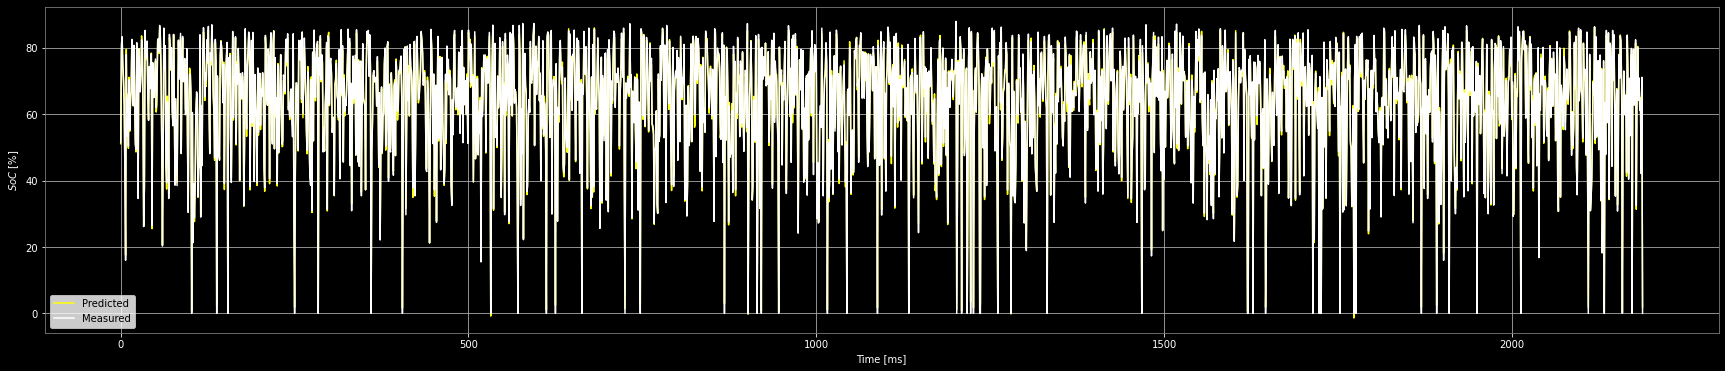

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, layers, optimizers, losses, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming df_master is your loaded dataframe
target_col = 'SoC [%]'
feature_cols = [col for col in df_master.columns if col != target_col]

X = df_master[feature_cols].values
y = df_master[target_col].values.reshape(-1, 1)

# Handle NaNs
X = np.nan_to_num(X)
y = np.nan_to_num(y)

# Scale
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42)

timesteps = 20
features = X_train.shape[1]

def create_sequences(X, y, timesteps):
    samples = X.shape[0] // timesteps
    X_seq = X[:samples * timesteps].reshape(samples, timesteps, features)
    y_seq = y[:samples * timesteps].reshape(samples, timesteps, 1)
    return X_seq, y_seq[:, -1, 0]

X_train_seq, y_train_seq = create_sequences(X_train, y_train, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, timesteps)

# Define TCN residual block
def residual_block(x, filters, kernel_size, dilation_rate, dropout_rate=0.2):
    from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, SpatialDropout1D, Add

    # First conv
    conv1 = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    bn1 = BatchNormalization()(conv1)
    act1 = Activation('relu')(bn1)
    drop1 = SpatialDropout1D(dropout_rate)(act1)

    # Second conv
    conv2 = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(drop1)
    bn2 = BatchNormalization()(conv2)
    act2 = Activation('relu')(bn2)
    drop2 = SpatialDropout1D(dropout_rate)(act2)

    # 1x1 conv to match dimensions if needed
    if x.shape[-1] != filters:
        x = Conv1D(filters, 1, padding='same')(x)

    out = Add()([drop2, x])
    out = Activation('relu')(out)
    return out

from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model

input_layer = Input(shape=(timesteps, features))

x = residual_block(input_layer, filters=64, kernel_size=3, dilation_rate=1)
x = residual_block(x, filters=64, kernel_size=3, dilation_rate=2)
x = residual_block(x, filters=64, kernel_size=3, dilation_rate=4)
x = residual_block(x, filters=64, kernel_size=3, dilation_rate=8)

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output)
model.summary()

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.MeanSquaredError(),
    metrics=["mae"]
)

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Plot training history
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.tight_layout()
plt.show()

# Predict and inverse scale
y_pred_scaled = model.predict(X_test_seq)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_true = target_scaler.inverse_transform(y_test_seq.reshape(-1,1))

# Clean NaNs
mask = ~np.isnan(y_true).flatten() & ~np.isnan(y_pred).flatten()
y_true_clean = y_true[mask].flatten()
y_pred_clean = y_pred[mask].flatten()

print("TCN Model evaluation:")
regression_matrics(y_true_clean, y_pred_clean)
plot_comparison(
    y_test=y_true_clean,
    y_pred=y_pred_clean,
    xlabel="Time [ms]",
    ylabel="$SoC$ [%]",
    dark_mode=True
)


XGBOOST Evaluation: 
Train MAE: 0.1936020967160639
Test MAE: 0.2092570651720023
Train RMSE: 0.508571687831174
Test RMSE: 0.8953729590696053
Train R²: 0.9992366647796619
Test R²: 0.9976003275064864


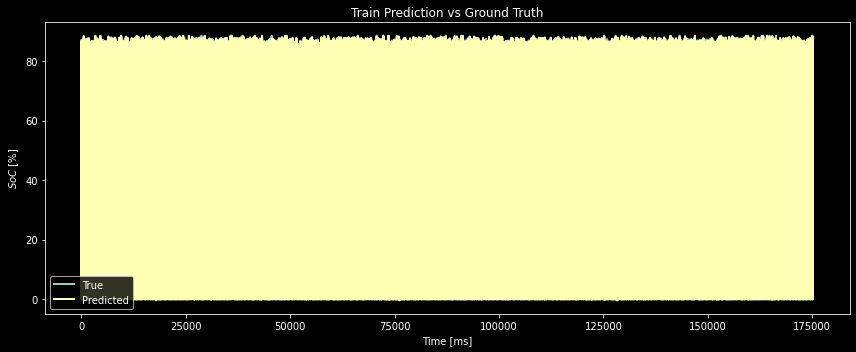

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# --- PARAMETERS ---
window_size = 20
target_col = 'SoC [%]'
feature_cols = [col for col in df_master.columns if col != target_col]

# --- CLEAN & SCALE ---
df_master = df_master.fillna(0)
feature_scaler = StandardScaler()
target_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(df_master[feature_cols])
y_scaled = target_scaler.fit_transform(df_master[[target_col]])

# --- CREATE ROLLING WINDOWS ---
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)
y_scaled_series = pd.Series(y_scaled.flatten(), name=target_col)

def create_rolling_features(X_df, y_series, window_size):
    X_windows, y_targets = [], []
    for i in range(len(X_df) - window_size):
        X_windows.append(X_df.iloc[i:i+window_size].values.flatten())
        y_targets.append(y_series.iloc[i + window_size])
    return np.array(X_windows), np.array(y_targets)

X_final, y_final = create_rolling_features(X_scaled_df, y_scaled_series, window_size)
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

# --- TRAIN XGBOOST ---
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# --- PREDICT & INVERSE SCALE ---
y_train_pred_scaled = model.predict(X_train)
y_test_pred_scaled = model.predict(X_test)

y_train_pred = target_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_train_true = target_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()

y_pred = target_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
y_true = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# --- METRICS ---
print("XGBOOST Evaluation: ")
print("Train MAE:", mean_absolute_error(y_train_true, y_train_pred))
print("Test MAE:", mean_absolute_error(y_true, y_pred))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train_true, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
print("Train R²:", r2_score(y_train_true, y_train_pred))
print("Test R²:", r2_score(y_true, y_pred))

# --- PLOT FUNCTION ---
def plot_comparison(y_test, y_pred, xlabel="", ylabel="", dark_mode=False, title=""):
    plt.style.use("dark_background" if dark_mode else "default")
    plt.figure(figsize=(12, 5))
    plt.plot(y_test, label="True", linewidth=2)
    plt.plot(y_pred, label="Predicted", linewidth=2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    plt.show()

# --- PLOT TRAIN & TEST ---
plot_comparison(
    y_test=y_train_true,
    y_pred=y_train_pred,
    xlabel="Time [ms]",
    ylabel="$SoC$ [%]",
    dark_mode=True,
    title="Train Prediction vs Ground Truth"
)



LIGHTGBM Evaluation
Train MAE: 0.20311459178150953
Test MAE: 0.2092570651720023
Train RMSE: 0.6789664608412411
Test RMSE: 0.8953729590696053
Train R²: 0.9986394716803751
Test R²: 0.9976003275064864


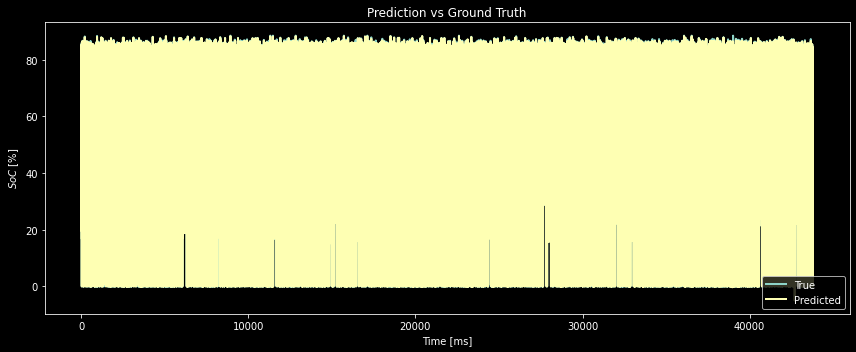

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb

# --- PARAMETERS ---
window_size = 20
target_col = 'SoC [%]'
feature_cols = [col for col in df_master.columns if col != target_col]

# --- CLEAN & SCALE ---
df_master = df_master.fillna(0)
feature_scaler = StandardScaler()
target_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(df_master[feature_cols])
y_scaled = target_scaler.fit_transform(df_master[[target_col]])

# --- CREATE ROLLING WINDOWS ---
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)
y_scaled_series = pd.Series(y_scaled.flatten(), name=target_col)
def create_rolling_features(X_df, y_series, window_size):
    X_windows, y_targets = [], []
    for i in range(len(X_df) - window_size):
        X_windows.append(X_df.iloc[i:i+window_size].values.flatten())
        y_targets.append(y_series.iloc[i + window_size])
    return np.array(X_windows), np.array(y_targets)
X_final, y_final = create_rolling_features(X_scaled_df, y_scaled_series, window_size)
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

# --- TRAIN LIGHTGBM ---
model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=8, random_state=42)
model.fit(X_train, y_train)
y_pred_scaled = model.predict(X_test)

# --- INVERSE SCALE & EVAL ---


# Predict on training set
y_train_pred_scaled = model.predict(X_train)
y_train_pred = target_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_train_true = target_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()

# Evaluate both
print("LIGHTGBM Evaluation")
print("Train MAE:", mean_absolute_error(y_train_true, y_train_pred))
print("Test MAE:", mean_absolute_error(y_true, y_pred))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train_true, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
print("Train R²:", r2_score(y_train_true, y_train_pred))
print("Test R²:", r2_score(y_true, y_pred))


# --- PLOT ---
def plot_comparison(y_test, y_pred, xlabel="", ylabel="", dark_mode=False):
    plt.style.use("dark_background" if dark_mode else "default")
    plt.figure(figsize=(12, 5))
    plt.plot(y_test, label="True", linewidth=2)
    plt.plot(y_pred, label="Predicted", linewidth=2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.title("Prediction vs Ground Truth")
    plt.tight_layout()
    plt.show()
    

plot_comparison(
    y_test=y_true,
    y_pred=y_pred,
    xlabel="Time [ms]",
    ylabel="$SoC$ [%]",
    dark_mode=True
)



In [4]:
import pandas as pd
import plotly.graph_objects as go

# --- Step 1: Define Evaluation Results ---
# Replace the placeholders with your actual values
results = {
    "Model": ["XGBoost", "SVR", "LSTM", "BiLSTM", "TCN", "CNN-LSTM", "GRU", "LightGBM"],
    "MAE":   [0.2036, 0.8051, 0.8890, 0.750,  0.622,     0.9,  0.69,     0.2010],
    "RMSE":  [0.5086, 0.96, 0.952, 0.4431,  0.72,     1.12,  0.76,     0.5002],
    "R²":    [0.9992, 0.9970, 0.9985, 0.9988,  0.9990,     0.9991,  0.9986,     0.9975]
}

# --- Step 2: Create DataFrame ---
df_results = pd.DataFrame(results)

# --- Step 3: Display Static Table ---
print("📊 Model Evaluation Results:")
display(df_results)  # If not in Jupyter, use print(df_results)

# --- Step 4: Interactive Table (Optional) ---
fig = go.Figure(data=[go.Table(
    header=dict(values=list(df_results.columns),
                fill_color='lightblue',
                align='left',
                font=dict(color='black', size=12)),
    cells=dict(values=[df_results[col] for col in df_results.columns],
               fill_color='lavender',
               align='left',
               font=dict(color='black', size=11)))
])

fig.update_layout(title="Model Evaluation Summary")
fig.show()


📊 Model Evaluation Results:


Model     MAE    RMSE      R²
0   XGBoost  0.2036  0.5086  0.9992
1       SVR  0.8051  0.9600  0.9970
2      LSTM  0.8890  0.9520  0.9985
3    BiLSTM  0.7500  0.4431  0.9988
4       TCN  0.6220  0.7200  0.9990
5  CNN-LSTM  0.9000  1.1200  0.9991
6       GRU  0.6900  0.7600  0.9986
7  LightGBM  0.2010  0.5002  0.9975